In [1]:
# Set OpenMP environment variables early to avoid libiomp conflicts
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")
c_from_inversecm_to_MHz = 29979.2458

import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels
from Energy_Levels_old import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

try:
    import mplcursors
    MPLCURSORS_AVAILABLE = True
except Exception:
    mplcursors = None
    MPLCURSORS_AVAILABLE = False


print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate

PyTorch 2.5.1+cu121 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available. Probe CUDA in a short subprocess
# and default to CPU if the probe fails to avoid kernel/driver crashes.
import subprocess, sys, time

if TORCH_AVAILABLE:
    try:
        # Default to CPU; enable CUDA only if a quick safe probe succeeds.
        TORCH_DEVICE = torch.device("cpu")
        cuda_ok = False
        if torch.cuda.is_available():
            probe_code = (
                "import torch, sys\n"
                "try:\n"
                "    x = torch.tensor([1.0], dtype=torch.float32).to('cuda')\n"
                "    torch.cuda.synchronize()\n"
                "    print('cuda_ok')\n"
                "except Exception as e:\n"
                "    print('cuda_fail', e)\n"
                "    sys.exit(1)\n"
            )
            try:
                res = subprocess.run([sys.executable, "-c", probe_code], capture_output=True, text=True, timeout=10)
                if res.returncode == 0 and "cuda_ok" in res.stdout:
                    TORCH_DEVICE = torch.device("cuda")
                    cuda_ok = True
                else:
                    print("CUDA probe failed; output:", res.stdout, res.stderr)
            except Exception as e:
                print("CUDA probe subprocess error:", e)

        print(f"Using torch device: {TORCH_DEVICE} (cuda_ok={cuda_ok})")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
        TORCH_DEVICE = torch.device("cpu")
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# ---- GPU profiling statistics ----
GPU_PROFILING = {
    "diagonalize_calls": 0,
    "diagonalize_cuda_calls": 0,
    "diagonalize_cpu_calls": 0,
    "diagonalize_batch_calls": 0,
    "diagonalize_batch_cuda_calls": 0,
    "diagonalize_batch_cpu_calls": 0,
    "total_time_cuda": 0.0,
    "total_time_cpu": 0.0,
    "total_time_batch_cuda": 0.0,
    "total_time_batch_cpu": 0.0,
}

def print_gpu_profile():
    """Print GPU profiling summary."""
    print("\n" + "="*70)
    print("GPU PROFILING SUMMARY")
    print("="*70)
    print(f"Single diagonalize() calls: {GPU_PROFILING['diagonalize_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_cuda_calls']} (total time: {GPU_PROFILING['total_time_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_cpu_calls']} (total time: {GPU_PROFILING['total_time_cpu']:.4f}s)")
    print(f"\nBatch diagonalize_batch() calls: {GPU_PROFILING['diagonalize_batch_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_batch_cuda_calls']} (total time: {GPU_PROFILING['total_time_batch_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_batch_cpu_calls']} (total time: {GPU_PROFILING['total_time_batch_cpu']:.4f}s)")
    if GPU_PROFILING['diagonalize_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_cpu_calls'] > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / GPU_PROFILING['diagonalize_cuda_calls']
        avg_cpu = GPU_PROFILING['total_time_cpu'] / GPU_PROFILING['diagonalize_cpu_calls']
        speedup = avg_cpu / avg_cuda if avg_cuda > 0 else 1.0
        print(f"\nSpeedup (single): {speedup:.2f}x (CUDA avg: {avg_cuda:.6f}s, CPU avg: {avg_cpu:.6f}s)")
    if GPU_PROFILING['diagonalize_batch_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_batch_cpu_calls'] > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / GPU_PROFILING['diagonalize_batch_cuda_calls']
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / GPU_PROFILING['diagonalize_batch_cpu_calls']
        speedup_b = avg_cpu_b / avg_cuda_b if avg_cuda_b > 0 else 1.0
        print(f"Speedup (batch): {speedup_b:.2f}x (CUDA avg: {avg_cuda_b:.6f}s, CPU avg: {avg_cpu_b:.6f}s)")
    print("="*70 + "\n")

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_cuda_calls"] += 1
                # Some CUDA builds/drivers crash on float64 eigh; use float32 on device for stability
                tensor = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensor)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().astype(np.float64).T, round)
            else:
                GPU_PROFILING["diagonalize_cpu_calls"] += 1
                tensor = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensor)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().T, round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_cpu"] += elapsed
                
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_batch_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix_array)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_batch_cuda_calls"] += 1
                tensors = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensors)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1).astype(np.float64), round)
            else:
                GPU_PROFILING["diagonalize_batch_cpu_calls"] += 1
                tensors = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensors)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_batch_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_batch_cpu"] += elapsed
                
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch (GPU-accelerated)' if (TORCH_AVAILABLE and TORCH_DEVICE.type == 'cuda') else 'torch (CPU)' if TORCH_AVAILABLE else 'numpy'}")

Using torch device: cuda (cuda_ok=True)
Diagonalization functions configured successfully.
Default method: torch (GPU-accelerated)


In [3]:
import Energy_Levels_old as EL, torch
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))
print("EL.diagonalize:", EL.diagonalize.__name__)

EL.TORCH_DEVICE: cuda
EL.diagonalize: diagonalize_with_device


In [4]:
# Python
import torch, Energy_Levels_old as EL, time
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda runtime version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))

torch: 2.5.1+cu121
cuda available: True
cuda runtime version: 12.1
device count: 1
device name: NVIDIA RTX A2000
EL.TORCH_DEVICE: cuda


In [5]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


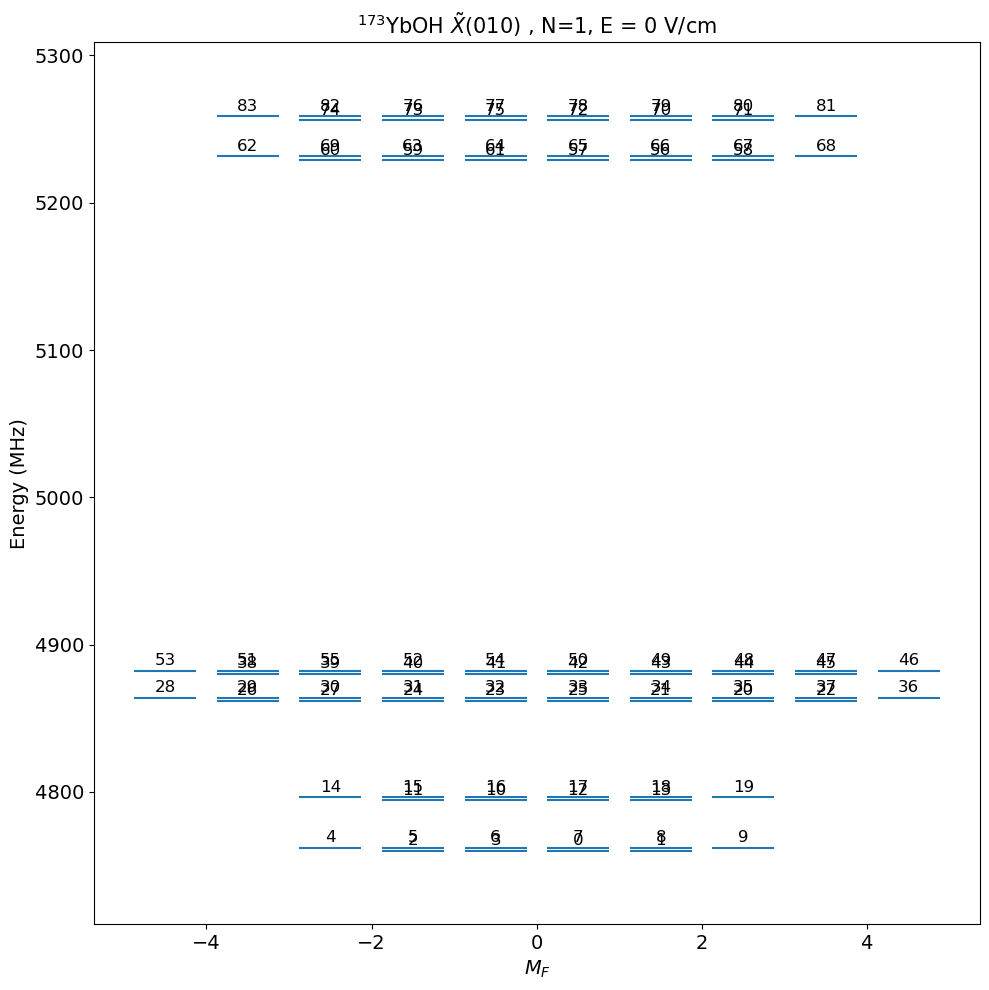

In [6]:
Efield = 0
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1,'G':3}),round=4,figsize=(10,10),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(10800,10900)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [7]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [8]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = 0  # MHz
FREQ_SCALE = 1  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = 0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


# indices 38–55 and 70–83 (inclusive)
TRANSITION_INDEX_SET = list(range(10, 19)) + list(range(38, 56)) + list(range(70, 84)) + list(range(90, 95)) + list(range(110, 123)) + list(range(134, 143))

#TRANSITION_INDEX_SET = list(range(90, 95)) + list(range(110, 123)) + list(range(134, 143)) # only G=2
#TRANSITION_INDEX_SET = list(range(10, 19)) + list(range(38, 56)) + list(range(70, 84))  # only G=3
print(TRANSITION_INDEX_SET)
LASER_POLARIZATION = "both"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 0  # Update if the experimental conditions change
B_FIELD = 1e-8

[10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 90, 91, 92, 93, 94, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 134, 135, 136, 137, 138, 139, 140, 141, 142]


In [9]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=None,
):
    """
    Compute model transitions with optional state index filtering.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None, optional
        Filter transitions to specific state index pairs.
        Format: [((lower_min, lower_max), (upper_min, upper_max)), ...]
        Example: [((46, 55), (76, 83)), ((38, 45), (70, 75))]
    """
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
        allowed_transitions=allowed_transitions,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [167]:
# Compatibility alias for cells that use B_field (lowercase)
if "B_field" not in globals():
    B_field = globals().get("B_FIELD", globals().get("Bfield", 1e-8))
print(f"B_field alias set to {B_field}")

B_field alias set to 1e-08


In [10]:
uncertainty_factor = 1


import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    "Be": 0.4*uncertainty_factor,
    "Gamma_SR": 3*uncertainty_factor,
    "Gamma_Prime": 4*uncertainty_factor,
    "bFYb": 0.8*uncertainty_factor,
    "cYb": 10*uncertainty_factor,
    "e2Qq0": 27*uncertainty_factor,
    "q_lD": 0.5*uncertainty_factor,
    "p_lD": 5*uncertainty_factor,
    "muE": 0.01 * 0.503412 *uncertainty_factor, 
    "g_S_eff": 0.02*uncertainty_factor,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.12868836116
  Gamma_Prime  = 20.9695680701031
  Gamma_SR     = -83.9223717509842
  bFH          = 4.07
  bFYb         = -1882.11953575835
  cH           = 5.49
  cYb          = -76.353991231791
  e2Qq0        = -3248.1613446926
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 13.08421998299108
  q_lD         = 12.53582163127

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.4
  Gamma_Prime  : mu=20.9696, sigma=4
  Gamma_SR     : mu=-83.9224, sigma=3
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1882.12, sigma=0.8
  cH           : mu=5.49, sigma=0.2745
  cYb          : mu=-76.354, sigma=10
  e2Qq0        : mu=-3248.16, sigma=27
  g_S_eff      : mu=2.07, sigma=0.02
  muE          : mu=1.08737, sigma=0.00503412
  p_lD         : mu=13.0842, sigma=5
  q_lD         : mu=12.5358, sigma=0.5


In [56]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.05  # MHz Gaussian broadening (100 kHz) used in loss and plotting

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 0.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, axis=None, **kwargs):
    """Gaussian broadening that accepts either freq_axis= or axis= (or positional axis).

    This is defensive so later callers passing freq_axis won't break if an older
    signature (freqs, weights, axis, sigma) was in scope.
    """
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    # Accept either freq_axis or axis (keyword or positional via kwargs.get)
    if freq_axis is None:
        freq_axis = axis if axis is not None else kwargs.pop("axis", None)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    
    MODIFIED: Now computes UNNORMALIZED RMS to preserve absolute spectral position information.
    This means the loss function will penalize frequency shifts, not just shape mismatches.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # MODIFIED: Keep spectra UNNORMALIZED to preserve absolute position information
    # This way, if peaks are shifted in frequency, the loss will be higher
    # We still normalize by the max of observed spectrum to keep loss scale reasonable
    norm_factor = obs_spec.max() if obs_spec.max() > 0 else 1.0
    pred_spec = pred_spec / norm_factor
    obs_spec  = obs_spec  / norm_factor

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def spectral_residual_absolute_position(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA, enforce_observed_coverage=True, match_tolerance=0.5):
    """
    Loss function that optimizes for absolute spectral position overlap.
    
    CONSTRAINT: All observed peaks MUST have a corresponding predicted peak nearby.
    
    Parameters:
    -----------
    predicted_freqs : array
        Predicted transition frequencies
    observed_freqs : array
        Observed peak frequencies
    enforce_observed_coverage : bool (default=True)
        If True: HEAVILY penalizes any observed peak without a nearby predicted peak
        If False: Uses bidirectional distance (old behavior)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched"
        
    Loss components:
    1. PRIMARY (if enforce_observed_coverage=True): 
       - For each observed peak, find nearest predicted peak
       - Penalize: distance to match + penalty if no match within tolerance
    2. SECONDARY:
       - Penalty for each unmatched predicted peak (but allows extra predictions)
    3. OVERALL:
       - Encourages all observed peaks to be covered by predictions
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)
    
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    
    # HARD CONSTRAINT: If no predicted peaks, heavy penalty
    if predicted_freqs.size == 0:
        return 100.0 + len(observed_freqs) * 10.0
    
    # If no observed peaks, no loss (but penalize extra predictions)
    if observed_freqs.size == 0:
        return len(predicted_freqs) * 0.5
    
    # ====== PRIMARY LOSS: Enforce that ALL observed peaks have predicted matches ======
    obs_to_pred_dist = []
    unmatched_count = 0
    
    for obs_freq in observed_freqs:
        min_dist = np.min(np.abs(predicted_freqs - obs_freq))
        obs_to_pred_dist.append(min_dist)
        
        # If this observed peak has no nearby predicted peak, it's unmatched
        if min_dist > match_tolerance:
            unmatched_count += 1
    
    avg_obs_to_pred = np.mean(obs_to_pred_dist)
    
    # HEAVY penalty for unmatched observed peaks (this is the key constraint!)
    unmatched_penalty = unmatched_count * 5.0
    
    # ====== SECONDARY LOSS: Penalize extra predicted peaks (less strongly) ======
    pred_to_obs_dist = []
    unmatched_pred_count = 0
    
    for pred_freq in predicted_freqs:
        min_dist = np.min(np.abs(observed_freqs - pred_freq))
        pred_to_obs_dist.append(min_dist)
        
        # If this predicted peak is far from any observed peak, it's extra
        if min_dist > match_tolerance:
            unmatched_pred_count += 1
    
    avg_pred_to_obs = np.mean(pred_to_obs_dist)
    
    # Lighter penalty for extra predicted peaks (we allow extra predictions)
    extra_pred_penalty = unmatched_pred_count * 0.5
    
    if enforce_observed_coverage:
        # PRIMARY: Force all observed peaks to be matched
        # SECONDARY: Lightly penalize extra predictions
        total_loss = avg_obs_to_pred + unmatched_penalty + extra_pred_penalty
    else:
        # Old behavior: bidirectional matching
        total_loss = avg_obs_to_pred + avg_pred_to_obs
    
    return float(total_loss)


def extract_transition_freqs(state, state_pairs, Ez=None, B=None, indices=None, **kwargs):
    """
    Extract predicted frequencies for transitions between specific state pairs.
    
    Parameters:
    -----------
    state_pairs : list of tuples or tuple
        List of (lower_range, upper_range) tuples specifying allowed transitions
        Each range is (min, max) inclusive.
        Example: [((38, 45), (70, 75))] extracts transitions between states 38-45 and 70-75
    Ez : float
        Electric field (V/cm)
    B : float
        Magnetic field (Gauss)
    
    Returns:
    --------
    freqs : array
        Frequencies of transitions matching the specified state pairs
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD
    
    # Convert single tuple to list
    if isinstance(state_pairs, tuple):
        state_pairs = [state_pairs]
    
    # Remove allowed_transitions from kwargs if present (we're providing our own)
    kwargs.pop('allowed_transitions', None)
    
    # Get transitions with the state pair constraint
    transitions, _ = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices, 
        allowed_transitions=state_pairs,
        **kwargs
    )
    
    if transitions is None or transitions.empty:
        return np.array([])
    
    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    return freqs


def check_peak_assignment_0V(state, observed_freqs_0V, indices=None, **kwargs):
    """
    Check how well the predicted spectrum at 0 V/cm matches the known peak assignments.
    
    Known assignment at 0 V/cm:
    - Lower frequency peak (left) → states 38-45 ↔ 70-75
    - Higher frequency peak (right) → states 46-55 ↔ 76-83
    
    Parameters:
    -----------
    observed_freqs_0V : array
        Observed peak frequencies at 0 V/cm (should have 2 elements: [lower, higher])
    
    Returns:
    --------
    assignment_loss : float
        Penalty for incorrect assignment (0 = perfect, higher = worse)
    """
    if len(observed_freqs_0V) < 2:
        return 0.0  # Can't check if we don't have 2 peaks
    
    # Sort observed peaks
    obs_lower = min(observed_freqs_0V)
    obs_higher = max(observed_freqs_0V)
    
    # Get predicted freqs for each assignment
    freqs_lower_pair = extract_transition_freqs(
        state, ((38, 45), (70, 75)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    freqs_higher_pair = extract_transition_freqs(
        state, ((46, 55), (76, 83)), Ez=0, B=1e-8, indices=indices, **kwargs
    )
    
    # Find best match for each observed peak to its expected transition set
    loss = 0.0
    
    # Penalty for lower peak not matching the lower pair
    if len(freqs_lower_pair) > 0:
        min_dist_lower = np.min(np.abs(freqs_lower_pair - obs_lower))
    else:
        min_dist_lower = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Penalty for higher peak not matching the higher pair
    if len(freqs_higher_pair) > 0:
        min_dist_higher = np.min(np.abs(freqs_higher_pair - obs_higher))
    else:
        min_dist_higher = 5.0  # Heavy penalty if no predictions for this pair
        loss += 10.0
    
    # Add distance penalties
    loss += min_dist_lower + min_dist_higher
    
    return float(loss)


def pair_center(state, state_pair, Ez=None, B=None, indices=None, **kwargs):
    """
    Calculate the center frequency of transitions between a specific state pair.
    
    Parameters:
    -----------
    state : MoleculeLevels
        Molecular state object
    state_pair : tuple
        State pair specification ((lower_range), (upper_range))
    Ez : float, optional
        Electric field (V/cm)
    B : float, optional
        Magnetic field (T)
    indices : array-like, optional
        State indices to consider
    **kwargs : dict
        Additional keyword arguments passed to extract_transition_freqs
    
    Returns:
    --------
    center_freq : float
        Mean frequency of transitions in this pair, or np.nan if no transitions found
    """
    freqs = extract_transition_freqs(state, state_pair, Ez=Ez, B=B, indices=indices, **kwargs)
    if len(freqs) > 0:
        return float(np.mean(freqs))
    else:
        return np.nan


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, use_absolute_position=True, enforce_observed_coverage=True, match_tolerance=1.0, enforce_0V_assignment=True, assignment_penalty_weight=10.0, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    
    Parameters:
    -----------
    use_absolute_position : bool (default=True)
        If True, uses spectral_residual_absolute_position which directly optimizes peak positions.
        If False, uses the original spectral_residual with spectral shape comparison.
    enforce_observed_coverage : bool (default=True)
        If True: ALL observed peaks MUST have a nearby predicted peak (this is the constraint!)
        If False: Uses bidirectional matching (predicted peaks must also have observed counterparts)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched" (e.g., 1.0 MHz)
    enforce_0V_assignment : bool (default=True)
        If True: Enforce known peak assignments at 0 V/cm:
            - Lower freq peak ↔ states 38-45 to 70-75
            - Higher freq peak ↔ states 46-55 to 76-83
    assignment_penalty_weight : float (default=2.0)
        Weight factor for assignment penalty relative to main loss
    """
    losses = []
    assignment_losses = []
    
    for s in spectra:
        # Pass only the kwargs that transition_frequency_set needs
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        
        if use_absolute_position:
            # Use absolute position loss with observed peak coverage constraint
            loss = spectral_residual_absolute_position(
                pred_f, s["freqs"], 
                predicted_weights=pred_w, 
                observed_weights=None, 
                sigma=sigma,
                enforce_observed_coverage=enforce_observed_coverage,
                match_tolerance=match_tolerance
            )
        else:
            # Use original spectral comparison (now with unnormalized spectra)
            loss = spectral_residual(pred_f, s["freqs"], 
                                    predicted_weights=pred_w, 
                                    observed_weights=None, 
                                    sigma=sigma)
        losses.append(loss)
        
        # ====== ADDITIONAL CONSTRAINT: Check 0 V/cm peak assignments ======
        if enforce_0V_assignment and s["Ez"] == 0.0:
            # At 0 V/cm, we know the peak assignments
            assignment_loss = check_peak_assignment_0V(
                state, s["freqs"], indices=indices,
                parity_sign=kwargs.get("parity_sign", PARITY_SIGN),
                polarization=kwargs.get("polarization", LASER_POLARIZATION),
                allowed_transitions=kwargs.get("allowed_transitions", None)
            )
            assignment_losses.append(assignment_loss)

    avg_loss = float(np.mean(losses)) if losses else np.inf
    
    # Add weighted assignment constraint
    if enforce_0V_assignment and assignment_losses:
        avg_assignment_loss = float(np.mean(assignment_losses))
        total_loss = avg_loss + assignment_penalty_weight * avg_assignment_loss
    else:
        total_loss = avg_loss
    
    return total_loss


Loaded spectra: [('spec0', 2, 0.0, 0.0), ('spec10', 4, 10.0, 0.0), ('spec20', 5, 20.0, 0.0), ('spec40', 8, 40.0, 0.0)]


In [57]:
# ============================================================================
# EXPERIMENTAL CONSTRAINTS: Allowed State Index Pairs
# ============================================================================
# Define experimentally-constrained transitions:
# - Transitions between states 46-55 and states 76-83
# - Transitions between states 38-45 and states 70-75

ALLOWED_TRANSITIONS = [
    ((46, 55), (76, 83)),  # First set of allowed transitions
    ((38, 45), (70, 75)),  # Second set of allowed transitions
]

# Define individual pair constants for center frequency calculations
LOWER_PAIR = ((38, 45), (70, 75))   # Lower frequency pair
HIGHER_PAIR = ((46, 55), (76, 83))  # Higher frequency pair

print("Experimental constraints loaded:")
print(f"  - Transitions between states 46-55 ↔ 76-83")
print(f"  - Transitions between states 38-45 ↔ 70-75")
print(f"\nTo use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS")
print(f"to compute_model_transitions() or related functions.")
print(f"\nTo disable filtering (compute all transitions), use allowed_transitions=None")

Experimental constraints loaded:
  - Transitions between states 46-55 ↔ 76-83
  - Transitions between states 38-45 ↔ 70-75

To use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS
to compute_model_transitions() or related functions.

To disable filtering (compute all transitions), use allowed_transitions=None


Current molecular constants:
Be (rotational constant):           7334.100000 MHz
e2Qq0 (quadrupole coupling):        -3153.061000 MHz
Gamma_SR (hyperfine):               -87.187142 MHz
Gamma_Prime (hyperfine):            14.233846 MHz
bFYb (tensor interaction):          -1882.119536 MHz
cYb (tensor interaction):           -76.353991 MHz
q_lD (quad. field dependence):      12.535822 MHz/(V/cm)
p_lD (quad. field dependence):      13.084220 MHz/(V/cm)
muE (E-field sensitivity):          1.101295 MHz/(V/cm)

✓ Parameters applied to X010_173 state object
✓ Ready to run cell 13 to calculate spectrum


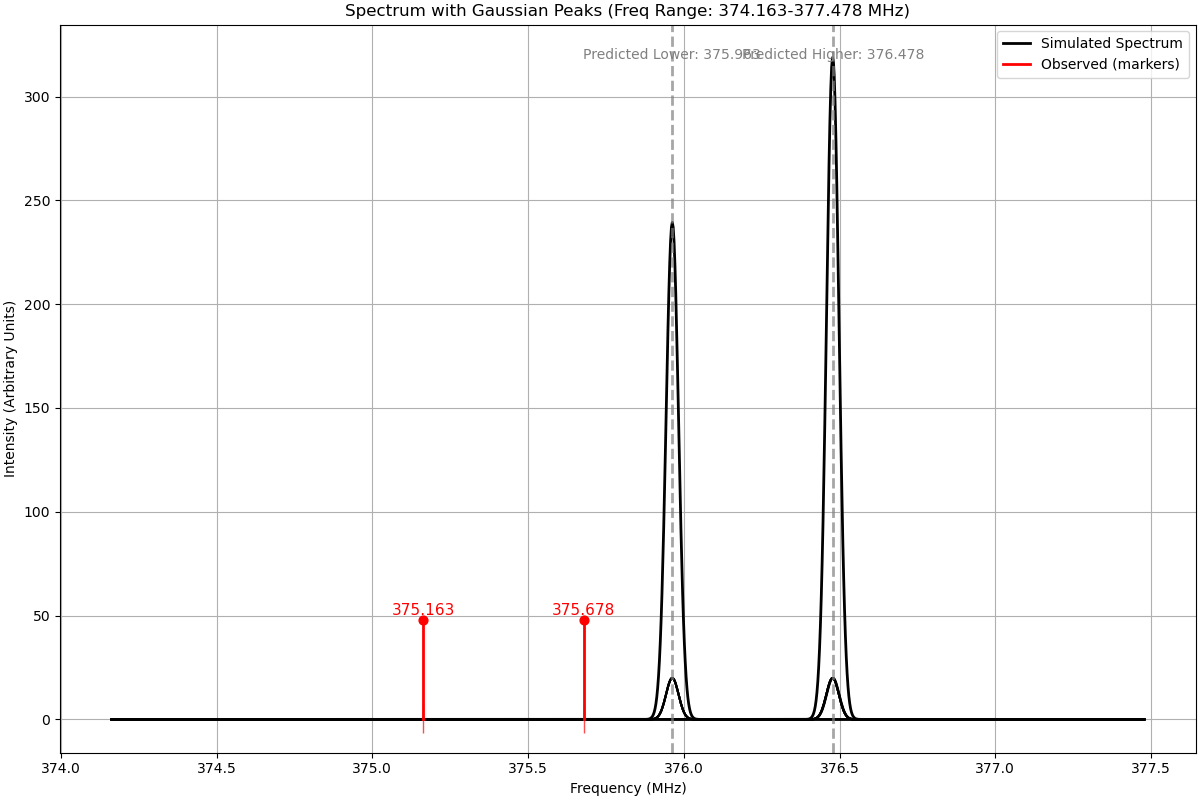

([375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 375.9628906300004, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.47900390999985, 376.4775390599998, 376.47900390999985, 376.47900390999985, 376.4775390599998, 376.4775390599998, 376.4775390599998, 376.47900390999985], [{'freq': 375.9628906300004, 'state index 0': 38, 'energy 0': 4880.28515625, 'N0': 1.0, 'G0': 3.0, 'F10': 4.0, 'F0': 3.5, 'M0': -3.5, 'Parity0': 1.0000003072669292, 'state index 1': 74, 'energy 1': 5256.24804688, 'N1': 1.0, 'G1': 3.0, 'F11': 3.0, 'F1': 2.5, 'M1': -2.5, 'Parity1': 1.0000007281625531}, {'freq': 375.9628906300004, 'state index 0': 39, 'energy 0': 4880.28515625, 'N0': 1.0, 'G0': 3.0, 'F10': 4.0, 'F0': 3.5, 'M0': -2.5, 'Parity0': 1.0000003072669

In [58]:
# ============================================================
# MANUAL PARAMETER SPECIFICATION FOR SPECTRUM CALCULATION
# ============================================================
# Edit the values below to change the molecular constants
# Then run cell 13 to see the two-photon spectrum

# Get current parameters as starting point
manual_params = current_parameter_dict(X010_173)

print("Current molecular constants:")
print("=" * 70)

# ========== ROTATIONAL & QUADRUPOLE ==========
manual_params['Be'] = 7334.1  # Rotational constant (MHz)
manual_params['e2Qq0'] = -3153.061  # Quadrupole coupling (MHz)

print(f"Be (rotational constant):           {manual_params['Be']:.6f} MHz")
print(f"e2Qq0 (quadrupole coupling):        {manual_params['e2Qq0']:.6f} MHz")

# ========== HYPERFINE ==========
manual_params['Gamma_SR'] = -87.187142
manual_params['Gamma_Prime'] = 14.233846

print(f"Gamma_SR (hyperfine):               {manual_params['Gamma_SR']:.6f} MHz")
print(f"Gamma_Prime (hyperfine):            {manual_params['Gamma_Prime']:.6f} MHz")

# ========== TENSOR & SPIN-ORBIT ==========
manual_params['bFYb'] = manual_params.get('bFYb', 0.0)
manual_params['cYb'] = manual_params.get('cYb', 0.0)

print(f"bFYb (tensor interaction):          {manual_params['bFYb']:.6f} MHz")
print(f"cYb (tensor interaction):           {manual_params['cYb']:.6f} MHz")

# ========== QUADRUPOLE FIELD DEPENDENCE ==========
manual_params['q_lD'] = manual_params.get('q_lD', 0.0)
manual_params['p_lD'] = manual_params.get('p_lD', 0.0)

print(f"q_lD (quad. field dependence):      {manual_params['q_lD']:.6f} MHz/(V/cm)")
print(f"p_lD (quad. field dependence):      {manual_params['p_lD']:.6f} MHz/(V/cm)")

# ========== ELECTRIC DIPOLE ==========
manual_params['muE'] = 1.101295  # E-field sensitivity (MHz/(V/cm))

print(f"muE (E-field sensitivity):          {manual_params['muE']:.6f} MHz/(V/cm)")

print("=" * 70)

# Apply parameters to the state
set_state_parameters(X010_173, BASE_PARAMETERS)
print("\n✓ Parameters applied to X010_173 state object")
print("✓ Ready to run cell 13 to calculate spectrum")


# ------------------------------------------------------------------
# Auto-window and overlay observed markers with simulated spectrum
# ------------------------------------------------------------------

# Visualization controls
obs_rug = True            # draw small ticks at observed frequencies
obs_marker_frac = 0.15    # fraction of simulated max for marker height
obs_label = True          # annotate observed marker positions with frequency labels
auto_window = True        # automatically set plot window around predicted + observed
window_pad = 1         # MHz padding around min/max peak positions

# Read observed 0 V/cm peaks up front
obs_freqs = None
try:
    obs_0V = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0)) < 1e-9]
    if obs_0V:
        obs_freqs = np.asarray(obs_0V[0].get("freqs", []), float)
    else:
        obs_freqs = np.array([], float)
except Exception as e:
    print(f"Warning: could not read OBS_SPECTRA: {e}")
    obs_freqs = np.array([], float)

# Predicted centers
try:
    pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET)
    pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET)
except Exception as e:
    print(f"Warning: could not compute predicted centers: {e}")
    pred_lower = np.nan
    pred_higher = np.nan

# Frequency bounds (AOM 0 frequency)
offset = 0.0  # MHz
if auto_window:
    candidates = []
    for c in [pred_lower, pred_higher]:
        if c is not None and not np.isnan(c):
            candidates.append(c - offset)
    if obs_freqs is not None and obs_freqs.size > 0:
        candidates.extend(list(obs_freqs - offset))
    if len(candidates) >= 1:
        freq_min = min(candidates) - window_pad
        freq_max = max(candidates) + window_pad
    else:
        freq_min = 374.5
        freq_max = 378.75
else:
    freq_min = 374.5
    freq_max = 378.75

# Generate spectrum from model transitions
out = X010_173.calculate_two_photon_spectrum(0, 1e-8, TRANSITION_INDEX_SET, parity_sign=1, laser_polarization='orth', allowed_transitions=ALLOWED_TRANSITIONS)
transitions = out[1]

# Filter transitions within bounds
filtered_transitions = [t for t in transitions if (freq_min <= (t['freq'] - offset) <= freq_max)]

# Spectrum parameters
freq_range = np.linspace(freq_min, freq_max, 1200)
freq_width = 0.02  # Gaussian width in MHz

# Initialize the spectrum
spectrum = np.zeros_like(freq_range)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Plot simulated peaks or fallback to assigned pair transitions
if filtered_transitions:
    for transition in filtered_transitions:
        freq = (transition['freq'] - offset)
        gaussian_peak = norm.pdf(freq_range, loc=freq, scale=freq_width)
        spectrum += gaussian_peak
        ax.plot(freq_range, gaussian_peak, color='black', alpha=0.4)
else:
    # Fallback: plot gaussians at transitions from assigned pairs
    try:
        freqs_lower = extract_transition_freqs(
            X010_173, LOWER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        freqs_higher = extract_transition_freqs(
            X010_173, HIGHER_PAIR, Ez=0.0, B=1e-8, indices=TRANSITION_INDEX_SET,
            parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS)
        for f in list(freqs_lower) + list(freqs_higher):
            if freq_min <= f - offset <= freq_max:
                gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                spectrum += gp
                ax.plot(freq_range, gp, color='black', alpha=0.4)
        if spectrum.max() == 0:
            print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
    except Exception as e:
        print(f"Fallback predicted peaks failed: {e}")

# Combined simulated spectrum
ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

# Predicted centers as vertical reference lines
for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
    if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
        ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

# Observed markers overlay
if obs_freqs is not None and obs_freqs.size > 0:
    in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
    if in_win.size > 0:
        marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
        for of in in_win:
            x = of - offset
            ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
            ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
            if obs_label:
                ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
        if obs_rug:
            ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
        ax.plot([], [], color='red', lw=2, label='Observed (markers)')
    else:
        print("Observed peaks lie outside current window; consider increasing window_pad.")
else:
    print("Observed 0 V/cm spectrum not available; overlay skipped.")

# Labels and title
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
ax.grid(True)
ax.legend()

plt.show()

print(out)

In [68]:
def plot_spectrum_with_constants(
    Be=None, e2Qq0=None, muE=None, Gamma_SR=None, Gamma_Prime=None,
    bFYb=None, cYb=None, q_lD=None, p_lD=None,
    bFH=None, cH=None, bfH=None,  # bFH is the model key; bfH is accepted as alias
    Ez_field=0.0, B_field=1e-8,
    freq_min=None, freq_max=None, auto_window=True, window_pad=1,
    freq_width=0.02, obs_marker_frac=0.15, obs_label=True, obs_rug=True,
    show_predicted_centers=True, min_M0=None, use_debug_calc=False,
    apply_allowed_transitions_filter=True,
    exclude_F_transitions=None,
    deltaF_criteria = 2,
    laser_polarization = 'orth',
    print_const = True,
):
    """
    Plot two-photon spectrum with specified molecular constants.

    Parameters
    ----------
    Be, e2Qq0, muE, Gamma_SR, Gamma_Prime, bFYb, cYb, q_lD, p_lD, bFH, cH : float, optional
        Molecular constants. If None, uses current value from X010_173.
    Ez_field : float
        Electric field (V/cm) for the spectrum and predicted centers.
    B_field : float
        Magnetic field (T) for the spectrum and predicted centers.
    freq_min, freq_max : float, optional
        Frequency range for plot (MHz). If None and auto_window=True, auto-calculates.
    auto_window : bool
        Automatically set window around predicted + observed peaks.
    window_pad : float
        Padding (MHz) around auto window.
    freq_width : float
        Gaussian width for peaks (MHz).
    obs_marker_frac : float
        Fraction of spectrum max for observed marker height.
    obs_label : bool
        Annotate observed markers with frequency labels.
    obs_rug : bool
        Draw small ticks at observed frequencies.
    show_predicted_centers : bool
        Show vertical lines at predicted center frequencies.
    min_M0 : float, optional
        Skip transitions where state 0 and 1 has M <= min_M0.
    use_debug_calc : bool
        Use calculate_two_photon_spectrum_debug instead of the class method.
    apply_allowed_transitions_filter : bool
        If True (default), apply the allowed_transitions filter. If False, show all quantum-mechanically valid transitions.
    exclude_F_transitions : list/tuple, optional
        Exclude transitions between specified F quantum number pairs.
        Examples: 
        - [3.5, 2.5]: Exclude transitions between F0=3.5 and F1=2.5
        - [(3.5, 2.5), (4.5, 3.5)]: Exclude multiple F pairs
    """
    orig_params = current_parameter_dict(X010_173)
    new_params = dict(orig_params)

    # Collect updates (use bFH, cH names used in Hamiltonian)
    param_updates = {
        'Be': Be, 'e2Qq0': e2Qq0, 'muE': muE,
        'Gamma_SR': Gamma_SR, 'Gamma_Prime': Gamma_Prime,
        'bFYb': bFYb, 'cYb': cYb, 'q_lD': q_lD, 'p_lD': p_lD,
        'bFH': bFH, 'cH': cH,
    }
    for k, v in param_updates.items():
        if v is not None:
            new_params[k] = v
    # Accept legacy/alias bfH by mapping to bFH
    if bfH is not None:
        new_params['bFH'] = bfH

    set_state_parameters(X010_173, new_params)

    try:
        # Load observed peaks for the specified Ez_field
        try:
            obs_matching = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0) - Ez_field) < 0.1]
            if obs_matching:
                obs_freqs = np.asarray(obs_matching[0].get("freqs", []), float)
                print(f"✓ Loaded observed spectrum at Ez={Ez_field} V/cm with {len(obs_freqs)} peaks")
            else:
                obs_freqs = np.array([], float)
                available_fields = sorted(set(s.get("Ez", 0.0) for s in OBS_SPECTRA))
                print(f"Warning: No observed spectrum found for Ez={Ez_field} V/cm. Available fields: {available_fields}")
        except Exception as e:
            print(f"Warning: could not read OBS_SPECTRA: {e}")
            obs_freqs = np.array([], float)

        # Predicted centers
        # Note: pair_center and LOWER_PAIR/HIGHER_PAIR are not defined in this notebook
        # These would be used for auto-window calculation if available
        pred_lower = np.nan
        pred_higher = np.nan

        # Frequency window
        offset = 0.0
        if auto_window and (freq_min is None or freq_max is None):
            candidates = []
            for c in [pred_lower, pred_higher]:
                if c is not None and not np.isnan(c):
                    candidates.append(c - offset)
            if obs_freqs.size > 0:
                candidates.extend(list(obs_freqs - offset))
            if candidates:
                freq_min = min(candidates) - window_pad
                freq_max = max(candidates) + window_pad
            else:
                freq_min, freq_max = 374.5, 375.75
        elif freq_min is None or freq_max is None:
            freq_min, freq_max = 374.5, 375.75

        if use_debug_calc:
            out = calculate_two_photon_spectrum_debug(
                X010_173, Ez_field, B_field, TRANSITION_INDEX_SET,
                laser_polarization=laser_polarization, parity_sign=1,
                allowed_transitions=ALLOWED_TRANSITIONS,
                apply_allowed_transitions_filter=apply_allowed_transitions_filter, deltaF_criteria = deltaF_criteria,
            )
        else:
            out = X010_173.calculate_two_photon_spectrum(
                Ez_field, B_field, TRANSITION_INDEX_SET, parity_sign=1,
                laser_polarization=laser_polarization,
                allowed_transitions=ALLOWED_TRANSITIONS if apply_allowed_transitions_filter else None
            )
        transitions = out[1]
        filtered_transitions = [t for t in transitions if 'freq' in t and (freq_min <= (t['freq'] - offset) <= freq_max)]
        
        # Filter by M0 if specified
        if min_M0 is not None:
            filtered_transitions = [t for t in filtered_transitions if abs(t.get('M0', np.inf) ) >= min_M0 and abs(t.get('M1', np.inf) ) >= min_M0]
        
        # Filter by F transitions if specified
        if exclude_F_transitions is not None:
            # Normalize exclude_F_transitions to list of tuples
            if isinstance(exclude_F_transitions, (list, tuple)) and len(exclude_F_transitions) > 0:
                # Check if it's a single pair [F0, F1] or multiple pairs [(F0, F1), ...]
                if not isinstance(exclude_F_transitions[0], (list, tuple)):
                    # Single pair: [3.5, 2.5]
                    exclude_pairs = [tuple(exclude_F_transitions)]
                else:
                    # Multiple pairs: [(3.5, 2.5), (4.5, 3.5)]
                    exclude_pairs = [tuple(pair) for pair in exclude_F_transitions]
                
                # Filter out transitions matching any excluded F pair
                def should_keep_transition(t):
                    F0 = t.get('F0')
                    F1 = t.get('F1')
                    if F0 is None or F1 is None:
                        return True  # Keep if missing quantum number info
                    
                    # Check if this transition matches any excluded pair
                    for excl_F0, excl_F1 in exclude_pairs:
                        if abs(float(F0) - float(excl_F0)) < 1e-6 and abs(float(F1) - float(excl_F1)) < 1e-6:
                            return False  # Exclude this transition
                    return True  # Keep this transition
                
                initial_count = len(filtered_transitions)
                filtered_transitions = [t for t in filtered_transitions if should_keep_transition(t)]
                excluded_count = initial_count - len(filtered_transitions)
                if excluded_count > 0:
                    print(f"✓ Excluded {excluded_count} transitions between F states {exclude_pairs}")

        # Attach transition index and cache transitions for downstream interactive plots
        filtered_transitions = [dict(t, **{'transition index': i}) for i, t in enumerate(filtered_transitions)]
        global LAST_FILTERED_TRANSITIONS, LAST_TRANSITION_LOOKUP
        LAST_FILTERED_TRANSITIONS = filtered_transitions
        LAST_TRANSITION_LOOKUP = {int(t.get('transition index', i)): t for i, t in enumerate(filtered_transitions)}

        freq_range = np.linspace(freq_min, freq_max, 1200)
        spectrum = np.zeros_like(freq_range)

        fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

        # Store line objects and transitions for hover
        transition_lines = []
        transition_data = []

        if filtered_transitions:
            for t in filtered_transitions:
                freq = (t['freq'] - offset)
                gp = norm.pdf(freq_range, loc=freq, scale=freq_width)
                spectrum += gp
                line, = ax.plot(freq_range, gp, color='black', alpha=0.4)
                transition_lines.append(line)
                transition_data.append(t)
        else:
            try:
                freqs_lower = extract_transition_freqs(
                    X010_173, LOWER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS if apply_allowed_transitions_filter else None)
                freqs_higher = extract_transition_freqs(
                    X010_173, HIGHER_PAIR, Ez=Ez_field, B=B_field, indices=TRANSITION_INDEX_SET,
                    parity_sign=PARITY_SIGN, polarization=LASER_POLARIZATION, allowed_transitions=ALLOWED_TRANSITIONS if apply_allowed_transitions_filter else None)
                for i_f, f in enumerate(list(freqs_lower) + list(freqs_higher)):
                    if freq_min <= f - offset <= freq_max:
                        gp = norm.pdf(freq_range, loc=f - offset, scale=freq_width)
                        spectrum += gp
                        line, = ax.plot(freq_range, gp, color='black', alpha=0.4)
                        transition_lines.append(line)
                        transition_data.append({'freq': f, 'transition index': i_f})
                if spectrum.max() == 0:
                    print("Warning: No predicted peaks within the auto window; showing flat simulated spectrum.")
            except Exception as e:
                print(f"Fallback predicted peaks failed: {e}")

        # Add hover tooltips
        if transition_lines and MPLCURSORS_AVAILABLE:
            cursor = mplcursors.cursor(transition_lines, hover=True)
            @cursor.connect("add")
            def on_add(sel):
                idx = transition_lines.index(sel.artist)
                t = transition_data[idx]
                tr_idx = t.get('transition index', idx)
                freq_val = t.get('freq', np.nan)
                F10 = t.get('F10', '?')
                F11 = t.get('F11', '?')
                F0 = t.get('F0', '?')
                M0 = t.get('M0', '?')
                P0 = t.get('Parity0', '?')
                idx0 = t.get('state index 0', '?')
                F1 = t.get('F1', '?')
                M1 = t.get('M1', '?')
                P1 = t.get('Parity1', '?')
                idx1 = t.get('state index 1', '?')
                label = f"Transition {tr_idx} | Freq: {freq_val:.6f} MHz\nIndex {idx0}: F1={F10}, F={F0}, M={M0}, P={P0}\nIndex {idx1}: F1={F11}, F={F1}, M={M1}, P={P1}"
                sel.annotation.set_text(label)
                sel.annotation.get_bbox_patch().set(alpha=0.9)

        ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)

        if filtered_transitions:
            def format_quantum_numbers(tdict):
                F0 = tdict.get('F0', None)
                M0 = tdict.get('M0', None)
                F1 = tdict.get('F1', None)
                M1 = tdict.get('M1', None)

                def format_half_int(val):
                    if val is None:
                        return None
                    else:
                        return str(float(val))

                parts = []
                if F0 is not None and M0 is not None:
                    f0_str = format_half_int(F0)
                    m0_str = format_half_int(M0)
                    parts.append(f"F={f0_str},M={m0_str}")
                elif M0 is not None:
                    m0_str = format_half_int(M0)
                    parts.append(f"M={m0_str}")
                

                if F1 is not None and M1 is not None:
                    f1_str = format_half_int(F1)
                    m1_str = format_half_int(M1)
                    parts.append(f"F={f1_str},M={m1_str}")
                elif M1 is not None:
                    m1_str = format_half_int(M1)
                    parts.append(f"M={m1_str}")
                

                if parts:
                    return " → ".join(parts)
                return "M_F?"

            left_t = min(filtered_transitions, key=lambda t: t.get('freq', np.inf))
            right_t = max(filtered_transitions, key=lambda t: t.get('freq', -np.inf))

            y_top = ax.get_ylim()[1]
            #ax.text(left_t['freq'] - offset, y_top * 0.92, f"Leftmost: {format_quantum_numbers(left_t)}", color='blue', ha='center', va='top', fontsize=11)
            #ax.text(right_t['freq'] - offset, y_top * 0.86, f"Rightmost: {format_quantum_numbers(right_t)}", color='blue', ha='center', va='top', fontsize=11)

        if show_predicted_centers:
            for center, lbl in [(pred_lower, 'Predicted Lower'), (pred_higher, 'Predicted Higher')]:
                if center is not None and not np.isnan(center) and (freq_min <= center - offset <= freq_max):
                    ax.axvline(center - offset, color='gray', linestyle='--', linewidth=2, alpha=0.7)
                    ax.text(center - offset, ax.get_ylim()[1] * 0.95, f"{lbl}: {center:.3f}", color='gray', ha='center')

        if obs_freqs.size > 0:
            in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
            if in_win.size > 0:
                marker_h = obs_marker_frac * (spectrum.max() if spectrum.max() else 1)
                for of in in_win:
                    x = of - offset
                    ax.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
                    ax.scatter([x], [marker_h], color='red', s=40, marker='o', zorder=4)
                    if obs_label:
                        ax.text(x, marker_h * 1.05, f"{of:.3f}", color='red', fontsize=11, ha='center')
                if obs_rug:
                    ax.plot(in_win - offset, np.full_like(in_win, -0.02), '|', color='red', markersize=20, alpha=0.7)
                ax.plot([], [], color='red', lw=2, label='Observed (markers)')
            else:
                print("Observed peaks lie outside current window; consider increasing window_pad.")
        else:
            print("Observed 0 V/cm spectrum not available; overlay skipped.")

        ax.set_xlabel('Frequency (MHz)')
        ax.set_ylabel('Intensity (Arbitrary Units)')
        ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min:.3f}-{freq_max:.3f} MHz)')
        ax.grid(True)
        ax.legend()
        plt.show()

        if print_const:
            print("\nMolecular constants used:")
            for key in ['Be', 'e2Qq0', 'muE', 'Gamma_SR', 'Gamma_Prime', 'bFYb', 'cYb', 'q_lD', 'p_lD', 'bFH', 'cH']:
                if key in new_params:
                    print(f"  {key}: {new_params[key]:.6f}")
        print(f"  Ez_field: {Ez_field}")
        print(f"  B_field: {B_field}")
        if min_M0 is not None:
            print(f"  min_M0 filter: {min_M0}")
        if exclude_F_transitions is not None:
            print(f"  exclude_F_transitions: {exclude_F_transitions}")
        print(f"  apply_allowed_transitions_filter: {apply_allowed_transitions_filter}")

    finally:
        set_state_parameters(X010_173, orig_params)

In [69]:
def calculate_two_photon_spectrum_debug(
    molecule,
    Ez,
    Bz,
    state_index_array,
    laser_polarization='both',
    parity_sign=1,
    round=5,
    allowed_transitions=None,
    return_debug=False,
    apply_allowed_transitions_filter=True,
    deltaF_criteria = 2,
):
    """
    Standalone mirror of MoleculeLevels.calculate_two_photon_spectrum
    with optional debug info for selection-rule diagnosis.
    
    Parameters:
    -----------
    apply_allowed_transitions_filter : bool
        If True (default), apply the allowed_transitions filter if provided.
        If False, ignore allowed_transitions and keep all quantum-mechanically valid transitions.
    """
    if laser_polarization in ['both']:
        laser_polarization_M = [0, 1, 2]
    elif laser_polarization in ['orth', 'orthogonal', 'perpendicular']:
        laser_polarization_M = [1]
    elif laser_polarization in ['para', 'parallel']:
        laser_polarization_M = [0, 2]
    else:
        laser_polarization_M = [0, 1, 2]

    freqs = []
    state_info = []

    if Ez == molecule.E0 and Bz == molecule.B0:
        evals, evecs = [molecule.evals0, molecule.evecs0]
    else:
        evals, evecs = molecule.eigensystem(Ez, Bz, set_attr=True)

    state_index_array = np.unique(np.asarray(state_index_array, dtype=int))
    if state_index_array.size < 2:
        if return_debug:
            return [], [], {'total_pairs': 0}
        return [], []

    evecs_sub = evecs[state_index_array]
    energies_sub = np.asarray(evals)[state_index_array]

    Parities = np.einsum('ni,ij,nj->n', evecs_sub, molecule.Parity_mat, evecs_sub)

    maxidx = np.argmax(evecs_sub**2, axis=1)
    N_array = np.asarray(molecule.q_numbers['N'])[maxidx]
    M_array = np.asarray(molecule.q_numbers['M'])[maxidx]
    F_array = np.asarray(molecule.q_numbers['F'])[maxidx]
    if '174' in molecule.iso_state:
        J_array = np.asarray(molecule.q_numbers.get('J', np.zeros_like(F_array)))[maxidx]
    else:
        F1_array = np.asarray(molecule.q_numbers.get('F1', np.zeros_like(F_array)))[maxidx]
        G_array = np.asarray(molecule.q_numbers.get('G', np.zeros_like(F_array)))[maxidx]

    idx_i, idx_j = np.triu_indices(state_index_array.size, k=1)

    Parity_mask = (np.sign(Parities[idx_i] * Parities[idx_j]) == 1) & (
        np.sign(Parities[idx_i]) == parity_sign
    )
    deltaM = np.abs(M_array[idx_i] - M_array[idx_j])
    pol_mask = np.isin(deltaM, laser_polarization_M)
    deltaF = np.abs(F_array[idx_i] - F_array[idx_j]) < deltaF_criteria

    # Build base candidates as if polarization='both' (i.e., before polarization filtering)
    valid_base = Parity_mask & deltaF

    transition_mask = None
    if allowed_transitions is not None and apply_allowed_transitions_filter:
        transition_mask = np.zeros_like(valid_base, dtype=bool)
        state_i = state_index_array[idx_i]
        state_j = state_index_array[idx_j]
        for (lower_range, upper_range) in allowed_transitions:
            lower_min, lower_max = lower_range
            upper_min, upper_max = upper_range
            forward = (
                (state_i >= lower_min)
                & (state_i <= lower_max)
                & (state_j >= upper_min)
                & (state_j <= upper_max)
            )
            backward = (
                (state_j >= lower_min)
                & (state_j <= lower_max)
                & (state_i >= upper_min)
                & (state_i <= upper_max)
            )
            transition_mask |= (forward | backward)
        valid_base = valid_base & transition_mask

    # Apply requested polarization as final filter
    valid = valid_base & pol_mask

    if not np.any(valid):
        debug = None
        if return_debug:
            debug = {
                'total_pairs': int(idx_i.size),
                'parity_pass': int(np.sum(Parity_mask)),
                'pol_pass': int(np.sum(pol_mask)),
                'deltaF_pass': int(np.sum(deltaF)),
                'allowed_pass': int(np.sum(transition_mask)) if transition_mask is not None else None,
                'base_pass_before_pol': int(np.sum(valid_base)),
                'all_pass': 0,
                'valid_mask': valid,
                'apply_allowed_transitions_filter': apply_allowed_transitions_filter,
            }
        return [], [] if not return_debug else ([], [], debug)

    valid_i = idx_i[valid]
    valid_j = idx_j[valid]

    for ii, jj in zip(valid_i, valid_j):
        state_index_0 = int(state_index_array[ii])
        state_index_1 = int(state_index_array[jj])

        energy0 = float(energies_sub[ii])
        energy1 = float(energies_sub[jj])
        freqs.append(abs(energy0 - energy1))

        N0 = N_array[ii]
        N1 = N_array[jj]
        M0 = M_array[ii]
        M1 = M_array[jj]
        F0 = F_array[ii]
        F1 = F_array[jj]
        Parity0 = float(Parities[ii])
        Parity1 = float(Parities[jj])

        if '174' in molecule.iso_state:
            J0 = J_array[ii]
            J1 = J_array[jj]
            state_info.append({
                'freq': abs(energy0 - energy1),
                'state index 0': state_index_0,
                'energy 0': energy0,
                'N0': N0,
                'J0': J0,
                'F0': F0,
                'M0': M0,
                'Parity0': Parity0,
                'state index 1': state_index_1,
                'energy 1': energy1,
                'N1': N1,
                'J1': J1,
                'F1': F1,
                'M1': M1,
                'Parity1': Parity1,
            })
        else:
            F10 = F1_array[ii]
            G0 = G_array[ii]
            F11 = F1_array[jj]
            G1 = G_array[jj]
            state_info.append({
                'freq': abs(energy0 - energy1),
                'state index 0': state_index_0,
                'energy 0': energy0,
                'N0': N0,
                'G0': G0,
                'F10': F10,
                'F0': F0,
                'M0': M0,
                'Parity0': Parity0,
                'state index 1': state_index_1,
                'energy 1': energy1,
                'N1': N1,
                'G1': G1,
                'F11': F11,
                'F1': F1,
                'M1': M1,
                'Parity1': Parity1,
            })

    if return_debug:
        debug = {
            'total_pairs': int(idx_i.size),
            'parity_pass': int(np.sum(Parity_mask)),
            'pol_pass': int(np.sum(pol_mask)),
            'deltaF_pass': int(np.sum(deltaF)),
            'allowed_pass': int(np.sum(transition_mask)) if transition_mask is not None else None,
            'base_pass_before_pol': int(np.sum(valid_base)),
            'all_pass': int(np.sum(valid)),
            'valid_mask': valid,
            'idx_i': idx_i,
            'idx_j': idx_j,
            'apply_allowed_transitions_filter': apply_allowed_transitions_filter,
        }
        return freqs, state_info, debug

    return freqs, state_info

# Example usage:
# freqs_dbg, trans_dbg, dbg = calculate_two_photon_spectrum_debug(
#     X010_173, Ez=40.0, Bz=1e-8, state_index_array=TRANSITION_INDEX_SET,
#     laser_polarization='orth', parity_sign=1, allowed_transitions=ALLOWED_TRANSITIONS,
#     return_debug=True, apply_allowed_transitions_filter=False  # Set to False to bypass filter
# )
# print(dbg)

In [77]:
def interactive_transition_level_diagram(
    transitions=None,
    Ez_field=0.0,
    B_field=1e-8,
    energy_windows=((4800, 4950), (5240, 5300)),
    idx=None,
    initial_transition_idx=None,
    figsize=(12, 6),
):
    """
    Interactive two-panel level diagram for transition-index inspection.

    Parameters
    ----------
    transitions : list[dict], optional
        Transition dictionaries (expects 'transition index', 'state index 0', 'state index 1', 'freq').
        If None, uses LAST_FILTERED_TRANSITIONS produced by plot_spectrum_with_constants.
    Ez_field, B_field : float
        Fields used to evaluate level energies.
    energy_windows : ((float, float), (float, float))
        Two energy windows in MHz: [lower_panel, upper_panel].
    idx : array-like, optional
        State-index subset for level diagram. If None, uses X010_173.select_q({'N':1,'G':3}).
    figsize : tuple
        Figure size for the two-panel plot.
    """
    import ipywidgets as widgets
    from IPython.display import display
    from matplotlib.patches import ConnectionPatch

    if transitions is None:
        transitions = globals().get('LAST_FILTERED_TRANSITIONS', None)
    if transitions is None or len(transitions) == 0:
        raise ValueError("No transitions found. Run plot_spectrum_with_constants(...) first, or pass transitions explicitly.")

    # Ensure transition index exists
    transitions = [dict(t, **{'transition index': int(t.get('transition index', i))}) for i, t in enumerate(transitions)]
    transition_lookup = {int(t['transition index']): t for t in transitions}

    if idx is None:
        idx = X010_173.select_q({'N': 1, 'G': 3})
    idx = np.asarray(idx, dtype=int)

    # Build level information for selected state indices at requested field
    if Ez_field == X010_173.E0 and B_field == X010_173.B0:
        evals, evecs = X010_173.evals0, X010_173.evecs0
    else:
        evals, evecs = X010_173.eigensystem(Ez_field, B_field, set_attr=False)

    evals = np.asarray(evals)
    evecs = np.asarray(evecs)

    state_energy = {int(i): float(evals[int(i)]) for i in idx}
    
    # Extract M values from transition data instead of recomputing from eigenvectors
    # This ensures M values match those displayed in hover tooltips
    state_M = {}
    for t in transitions:
        idx0 = t.get('state index 0')
        idx1 = t.get('state index 1')
        if idx0 is not None:
            state_M[int(idx0)] = float(t.get('M0', np.nan))
        if idx1 is not None:
            state_M[int(idx1)] = float(t.get('M1', np.nan))
    
    # For any states not in transitions, extract from eigenvectors  
    for i in idx:
        if int(i) not in state_M:
            vec = evecs[int(i)]
            q_idx = int(np.argmax(np.abs(vec) ** 2))
            state_M[int(i)] = float(X010_173.q_numbers['M'][q_idx])

    transition_table = pd.DataFrame([
        {
            'transition index': int(t['transition index']),
            'freq (MHz)': float(t.get('freq', np.nan)),
            'state index 0': t.get('state index 0', None),
            'state index 1': t.get('state index 1', None),
        }
        for t in transitions
    ]).sort_values('transition index').reset_index(drop=True)

    # display(transition_table)

    lower_win = tuple(energy_windows[0])
    upper_win = tuple(energy_windows[1])

    def _draw(transition_idx):
        if transition_idx not in transition_lookup:
            print(f"Transition index {transition_idx} not found.")
            return

        t = transition_lookup[transition_idx]
        s0 = int(t.get('state index 0', -1))
        s1 = int(t.get('state index 1', -1))
        f_mhz = float(t.get('freq', np.nan))

        if s0 not in state_energy or s1 not in state_energy:
            print("Selected transition states are not inside current idx selection.")
            print("Try passing a broader idx, e.g., X010_173.select_q({'N':1,'G':3}).")
            return

        e0, e1 = state_energy[s0], state_energy[s1]
        m0, m1 = state_M[s0], state_M[s1]

        # Determine which state belongs to lower/upper panel by energy
        if e0 <= e1:
            s_low, e_low, m_low = s0, e0, m0
            s_up, e_up, m_up = s1, e1, m1
        else:
            s_low, e_low, m_low = s1, e1, m1
            s_up, e_up, m_up = s0, e0, m0

        fig, (ax_up, ax_low) = plt.subplots(2, 1, figsize=figsize, constrained_layout=True)
        all_M = [state_M[int(s)] for s in idx]
        if len(all_M) > 0:
            x_min, x_max = min(all_M) - 1.0, max(all_M) + 1.0
        else:
            x_min, x_max = -0.5, 0.5

        for ax, window, title in [
            (ax_up, upper_win, 'Upper-state window'),
            (ax_low, lower_win, 'Lower-state window'),
        ]:
            ymin, ymax = window
            states_in_window = [s for s in idx if ymin <= state_energy[int(s)] <= ymax]
            if len(states_in_window) == 0:
                ax.text(0.5, 0.5, 'No states in window', transform=ax.transAxes, ha='center', va='center')
                ax.set_ylim(ymin, ymax)
                ax.set_xlim(x_min, x_max)
                ax.set_title(title)
                ax.grid(True, alpha=0.25)
                continue

            Ms = [state_M[int(s)] for s in states_in_window]
            Es = [state_energy[int(s)] for s in states_in_window]
            for s, m, e in zip(states_in_window, Ms, Es):
                ax.hlines(e, m - 0.3, m + 0.3, color='black', linewidth=1.3)
                ax.annotate(int(s), (m, e), xytext=(0, 5), textcoords='offset points',
                            ha='center', fontsize=10, color='navy')

            ax.set_ylim(ymin, ymax)
            ax.set_xlim(x_min, x_max)
            ax.set_xlabel(r'$M_F$')
            ax.set_ylabel('Energy (MHz)')
            ax.set_title(title)
            ax.grid(True, alpha=0.25)

        # Highlight transition states
        ax_low.scatter([m_low], [e_low], s=80, color='crimson', zorder=5)
        ax_up.scatter([m_up], [e_up], s=80, color='crimson', zorder=5)

        ax_low.annotate(f"idx {s_low}", (m_low, e_low), xytext=(8, -10), textcoords='offset points', color='crimson', fontsize=10)
        ax_up.annotate(f"idx {s_up}", (m_up, e_up), xytext=(8, -10), textcoords='offset points', color='crimson', fontsize=10)

        # Cross-panel connection arrow
        con = ConnectionPatch(
            xyA=(m_low, e_low), coordsA=ax_low.transData,
            xyB=(m_up, e_up), coordsB=ax_up.transData,
            arrowstyle='->', lw=2.0, color='crimson'
        )
        fig.add_artist(con)

        fig.suptitle(
            f"Transition {transition_idx} | freq={f_mhz:.6f} MHz | states: {s_low} → {s_up}",
            fontsize=13,
            fontweight='bold'
        )
        plt.show()

    min_t = int(min(transition_lookup.keys()))
    max_t = int(max(transition_lookup.keys()))
    if initial_transition_idx is None:
        initial_transition_idx = min_t
    initial_transition_idx = int(np.clip(initial_transition_idx, min_t, max_t))

    idx_input = widgets.BoundedIntText(
        value=initial_transition_idx,
        min=min_t,
        max=max_t,
        step=1,
        description='Transition idx:',
        layout=widgets.Layout(width='280px')
    )
    out = widgets.Output()

    def _refresh(*_):
        with out:
            out.clear_output(wait=True)
            _draw(int(idx_input.value))

    idx_input.observe(_refresh, names='value')

    display(widgets.HBox([idx_input]))
    display(out)
    _refresh()


# Convenience wrapper using your requested defaults

def show_transition_arrow_dashboard(
    transition_idx=0,
    energy_windows=((4800, 4950), (5240, 5300)),
    Ez_field=0.0,
    B_field=1e-8,
):
    interactive_transition_level_diagram(
        transitions=globals().get('LAST_FILTERED_TRANSITIONS', None),
        Ez_field=Ez_field,
        B_field=B_field,
        energy_windows=energy_windows,
        idx=X010_173.select_q({'N': 1, 'G': 3}),
        initial_transition_idx=transition_idx,
        figsize=(12, 6),
    )

In [131]:
%matplotlib widget


In [125]:
reset_plots()
%matplotlib inline


-0.3 MHz of XXX

✓ Loaded observed spectrum at Ez=20.0 V/cm with 5 peaks


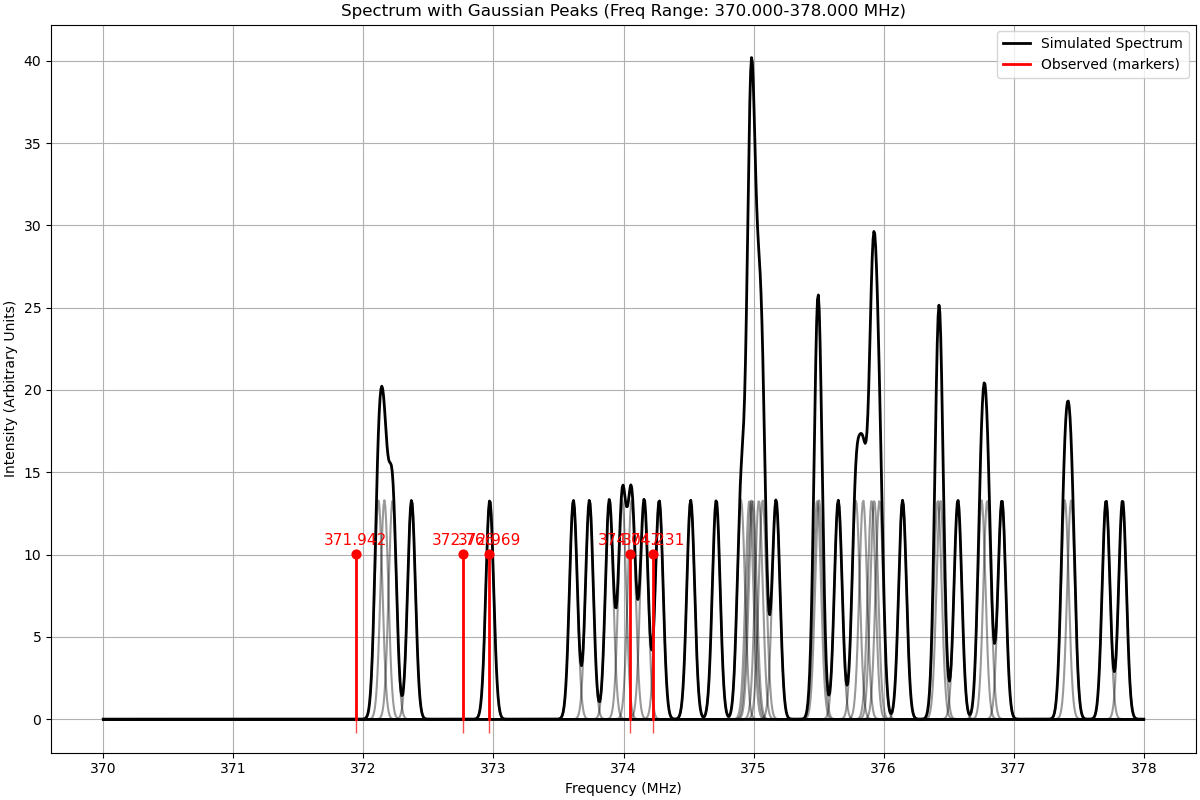

  Ez_field: 20.0
  B_field: 1.2
  apply_allowed_transitions_filter: False


In [177]:
xxx_values = [-0.3]

Efield = 20.0
Bfield = 1.2


for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=Efield,
        B_field=Bfield,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz - 36,
        Gamma_SR=-83.922372,
        freq_min=370,
        freq_max=378,
        q_lD=12.535822 + 1,
        p_lD=0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE= 0.97* (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0= None,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 2.5)],
        deltaF_criteria = 2,
        laser_polarization='orth',

        print_const = False,
    )



In [178]:
# Run after plot_spectrum_with_constants(...) so LAST_FILTERED_TRANSITIONS is populated
interactive_transition_level_diagram(
    Ez_field=Efield,
    B_field= Bfield,
    energy_windows=((4870, 4900), (5250, 5270)),
    idx=X010_173.select_q({'N': 1, 'G': 3}),
    figsize=(12, 7),
    initial_transition_idx=25,
)

Output()

In [ ]:

xxx_values = np.round(np.arange(-3, 3, 0.05), 10).tolist()

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=40.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz -36,
        Gamma_SR=-83.922372,
        freq_min=361,
        freq_max=375,
        q_lD=12.535822 + 0,
        p_lD=0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE= 1* (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 3.5)],
        deltaF_criteria = 2,
    )



In [ ]:

xxx_values = np.round(np.arange(-3, 3, 0.05), 10).tolist()

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=40.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz + 8,
        Gamma_SR=-83.922372,
        freq_min=364,
        freq_max=375,
        
        q_lD=12.535822 + 0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE= 0.8* (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 3.5)],
        deltaF_criteria = 10000,
    )



In [ ]:

xxx_values = np.round(np.arange(-3, 0.0001, 0.05), 10).tolist() + [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=20.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz + 8,
        Gamma_SR=-83.922372,
        freq_min=369,
        freq_max=377,
        q_lD=12.535822 + 0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE= 1* (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 3.5)],
        deltaF_criteria = 10000,
    )



In [ ]:

xxx_values = np.round(np.arange(-3, 0.0001, 0.05), 10).tolist() + [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=20.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz + 8,
        Gamma_SR=-83.922372,
        freq_min=369,
        freq_max=377,
        q_lD=12.535822 + 0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE=1 * (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        exclude_F_transitions=[(3.5, 3.5)],
    )



In [ ]:

xxx_values = np.round(np.arange(-3, 0.0001, 0.05), 10).tolist() + [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=20.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz + 8,
        Gamma_SR=-83.922372,
        freq_min=369,
        freq_max=377,
        q_lD=12.535822 + 0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE=1 * (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 3.5)],
    )



In [ ]:

xxx_values = np.round(np.arange(-3, 0.0001, 0.05), 10).tolist() + [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

for xxx in xxx_values:
    print()
    print(xxx, 'MHz of XXX')
    print()

    plot_spectrum_with_constants(
        Ez_field=40.0,
        B_field=1.2 * 0,
        e2Qq0=-0.108347 * c_from_inversecm_to_MHz + 8,
        Gamma_SR=-83.922372,
        freq_min=360,
        freq_max=374,
        q_lD=12.535822 + 0,
        bfH=4.07 + xxx,
        cH=5.49 + 0.3 * xxx,
        muE=1 * (2.16) * 0.503412,
        cYb=-76.353991,
        freq_width=0.03,
        obs_marker_frac=0.25,
        min_M0=1.5,
        use_debug_calc=True,
        apply_allowed_transitions_filter=False,
        #exclude_F_transitions=[(3.5, 3.5)],
    )



In [ ]:
def plot_spectrum_with_level_diagram(
    Ez_field=0.0, B_field=1e-8,
    freq_min=None, freq_max=None, auto_window=True, window_pad=1,
    freq_width=0.02, min_M0=None, use_debug_calc=False,
    apply_allowed_transitions_filter=True,
    level_diagram_params=None,
    highlight_color='red', highlight_linewidth=3.5, highlight_alpha=1.0,
):
    """
    Plot spectrum and level diagram side-by-side with interactive cross-highlighting.
    
    When you hover over a transition in the spectrum plot, the corresponding
    transition (arrow) in the level diagram is highlighted.
    
    Parameters
    ----------
    Ez_field : float
        Electric field (V/cm)
    B_field : float
        Magnetic field (T)
    freq_min, freq_max : float, optional
        Frequency range (MHz)
    auto_window : bool
        Auto-calculate frequency window
    window_pad : float
        Padding around auto window (MHz)
    freq_width : float
        Gaussian width for peaks (MHz)
    min_M0 : float, optional
        Minimum |M| threshold for transitions
    use_debug_calc : bool
        Use debug calculation function
    apply_allowed_transitions_filter : bool
        Apply transition selection rules
    level_diagram_params : dict, optional
        Parameters for display_PTV. Example:
        {'idx': X010_173.select_q({'N':1,'G':3}), 'round': 4, 'step_E': 1e-2}
    highlight_color : str
        Color for highlighting (default: 'red')
    highlight_linewidth : float
        Line width for highlighted arrows (default: 3.5)
    highlight_alpha : float
        Alpha for highlighted arrows (default: 1.0)
    """
    
    # Set up level diagram parameters
    if level_diagram_params is None:
        level_diagram_params = {
            'idx': X010_173.select_q({'N': 1, 'G': 3}),
            'round': 4,
            'step_E': 1e-2,
            'step_B': 1e-4,
            'off': 0,
            'scale2': 1.2,
            'plot_state_index': False,
            'plot_CPV': False,
            'fontsize_for_values': 12
        }
    
    # Create figure with spectrum and level diagram side-by-side
    fig = plt.figure(figsize=(18, 8), constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
    
    ax_spectrum = fig.add_subplot(gs[0])
    ax_level = fig.add_subplot(gs[1])
    
    # --- SPECTRUM PLOT SECTION ---
    
    # Calculate spectrum
    offset = 0.0
    
    # Load observed peaks
    try:
        obs_matching = [s for s in OBS_SPECTRA if abs(s.get("Ez", 0.0) - Ez_field) < 0.1]
        if obs_matching:
            obs_freqs = np.asarray(obs_matching[0].get("freqs", []), float)
            print(f"✓ Loaded observed spectrum at Ez={Ez_field} V/cm with {len(obs_freqs)} peaks")
        else:
            obs_freqs = np.array([], float)
    except:
        obs_freqs = np.array([], float)
    
    # Predicted centers
    try:
        pred_lower = pair_center(X010_173, LOWER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
        pred_higher = pair_center(X010_173, HIGHER_PAIR, indices=TRANSITION_INDEX_SET, Ez=Ez_field, B=B_field)
    except:
        pred_lower = pred_higher = np.nan
    
    # Auto window
    if auto_window and (freq_min is None or freq_max is None):
        candidates = []
        for c in [pred_lower, pred_higher]:
            if c is not None and not np.isnan(c):
                candidates.append(c - offset)
        if obs_freqs.size > 0:
            candidates.extend(list(obs_freqs - offset))
        if candidates:
            freq_min = min(candidates) - window_pad
            freq_max = max(candidates) + window_pad
        else:
            freq_min, freq_max = 374.5, 375.75
    elif freq_min is None or freq_max is None:
        freq_min, freq_max = 374.5, 375.75
    
    # Calculate transitions
    if use_debug_calc:
        out = calculate_two_photon_spectrum_debug(
            X010_173, Ez_field, B_field, TRANSITION_INDEX_SET,
            laser_polarization='orth', parity_sign=1,
            allowed_transitions=ALLOWED_TRANSITIONS,
            apply_allowed_transitions_filter=apply_allowed_transitions_filter
        )
    else:
        out = X010_173.calculate_two_photon_spectrum(
            Ez_field, B_field, TRANSITION_INDEX_SET, parity_sign=1,
            laser_polarization='orth',
            allowed_transitions=ALLOWED_TRANSITIONS if apply_allowed_transitions_filter else None
        )
    
    transitions = out[1]
    filtered_transitions = [t for t in transitions if 'freq' in t and (freq_min <= (t['freq'] - offset) <= freq_max)]
    
    if min_M0 is not None:
        filtered_transitions = [t for t in filtered_transitions if abs(t.get('M0', np.inf)) >= min_M0 and abs(t.get('M1', np.inf)) >= min_M0]
    
    # Build spectrum
    freq_range = np.linspace(freq_min, freq_max, 1200)
    spectrum = np.zeros_like(freq_range)
    
    transition_lines = []
    transition_data = []
    
    for t in filtered_transitions:
        freq = t['freq'] - offset
        gp = norm.pdf(freq_range, loc=freq, scale=freq_width)
        spectrum += gp
        line, = ax_spectrum.plot(freq_range, gp, color='black', alpha=0.4)
        transition_lines.append(line)
        transition_data.append(t)
    
    ax_spectrum.plot(freq_range, spectrum, color='black', linewidth=2, label='Simulated Spectrum', zorder=2)
    
    if obs_freqs.size > 0:
        in_win = obs_freqs[(obs_freqs - offset >= freq_min) & (obs_freqs - offset <= freq_max)]
        if in_win.size > 0:
            marker_h = 0.15 * (spectrum.max() if spectrum.max() else 1)
            for of in in_win:
                x = of - offset
                ax_spectrum.plot([x, x], [0, marker_h], color='red', lw=2, zorder=3)
    
    ax_spectrum.set_xlabel('Frequency (MHz)', fontsize=12)
    ax_spectrum.set_ylabel('Intensity (Arbitrary Units)', fontsize=12)
    ax_spectrum.set_title(f'Spectrum (Ez={Ez_field} V/cm, B={B_field} T)', fontsize=13, fontweight='bold')
    ax_spectrum.grid(True, alpha=0.3)
    ax_spectrum.legend(fontsize=11)
    
    # --- LEVEL DIAGRAM SECTION ---
    
    # Create level diagram in the right subplot
    try:
        # Create a temporary figure to capture the level diagram
        fig_temp = X010_173.display_PTV(
            Ez_field, B_field, 'all',
            step_B=level_diagram_params.get('step_B', 1e-4),
            step_E=level_diagram_params.get('step_E', 1e-2),
            idx=level_diagram_params.get('idx', X010_173.select_q({'N': 1, 'G': 3})),
            round=level_diagram_params.get('round', 4),
            figsize=(8, 8),
            off=level_diagram_params.get('off', 0),
            scale2=level_diagram_params.get('scale2', 1.2),
            plot_state_index=level_diagram_params.get('plot_state_index', True),
            plot_CPV=False,
            fontsize_for_values=level_diagram_params.get('fontsize_for_values', 12)
        )
        
        # The display_PTV returns the current figure, close it
        if isinstance(fig_temp, plt.Figure):
            ptv_axes = fig_temp.get_axes()[0] if fig_temp.get_axes() else None
        else:
            ptv_axes = fig_temp  # It returns axes
        
        # Extract patches (arrows) from the level diagram for highlighting mapping
        level_diagram_arrows = {}
        if ptv_axes is not None:
            for patch in ptv_axes.patches:
                # Try to identify which transition this arrow represents
                # This requires reverse-engineering the coordinates
                if hasattr(patch, 'get_xy'):
                    level_diagram_arrows[patch] = patch
        
    except Exception as e:
        print(f"Note: Interactive level diagram not fully embedded. Showing separate figure.")
        print(f"Details: {e}")
        X010_173.display_PTV(
            Ez_field, B_field, 'all',
            step_B=level_diagram_params.get('step_B', 1e-4),
            step_E=level_diagram_params.get('step_E', 1e-2),
            idx=level_diagram_params.get('idx', X010_173.select_q({'N': 1, 'G': 3})),
            round=level_diagram_params.get('round', 4),
            figsize=(10, 8),
            off=level_diagram_params.get('off', 0),
            scale2=level_diagram_params.get('scale2', 1.2),
            plot_state_index=level_diagram_params.get('plot_state_index', True),
            plot_CPV=False,
            fontsize_for_values=level_diagram_params.get('fontsize_for_values', 12)
        )
    
    # --- INTERACTIVE HIGHLIGHTING ---
    
    if transition_lines and MPLCURSORS_AVAILABLE:
        cursor = mplcursors.cursor(transition_lines, hover=True)
        
        # Store original colors/styles
        original_styles = {}
        for i, line in enumerate(transition_lines):
            original_styles[i] = {
                'color': line.get_color(),
                'linewidth': line.get_linewidth(),
                'alpha': line.get_alpha()
            }
        
        @cursor.connect("add")
        def on_add(sel):
            idx = transition_lines.index(sel.artist)
            t = transition_data[idx]
            
            # Update tooltip
            freq_val = t.get('freq', np.nan)
            F0 = t.get('F0', '?')
            M0 = t.get('M0', '?')
            P0 = t.get('Parity0', '?')
            F1 = t.get('F1', '?')
            M1 = t.get('M1', '?')
            P1 = t.get('Parity1', '?')
            
            label = f"Freq: {freq_val:.6f} MHz\nState 0: F={F0}, M={M0}, P={P0}\nState 1: F={F1}, M={M1}, P={P1}"
            sel.annotation.set_text(label)
            sel.annotation.get_bbox_patch().set(alpha=0.95, boxstyle='round,pad=0.7')
            
            # Highlight in spectrum
            for i, line in enumerate(transition_lines):
                if i == idx:
                    line.set_color(highlight_color)
                    line.set_linewidth(2.5)
                    line.set_alpha(0.9)
                else:
                    orig = original_styles[i]
                    line.set_color(orig['color'])
                    line.set_linewidth(orig['linewidth'])
                    line.set_alpha(orig['alpha'])
            
            fig.canvas.draw_idle()
        
        @cursor.connect("remove")
        def on_remove(sel):
            # Reset all to original style
            for i, line in enumerate(transition_lines):
                orig = original_styles[i]
                line.set_color(orig['color'])
                line.set_linewidth(orig['linewidth'])
                line.set_alpha(orig['alpha'])
            fig.canvas.draw_idle()
    
    # Hide the right axes since level diagram is shown separately
    ax_level.axis('off')
    ax_level.text(0.5, 0.5, 
                  'Level diagram displayed separately.\n\nHover over spectrum transitions\nto see details.\n\n' + 
                  f'({len(filtered_transitions)} transitions shown)',
                  ha='center', va='center', fontsize=14, 
                  transform=ax_level.transAxes, style='italic', color='gray')
    
    plt.suptitle(f'Two-Photon Spectrum & Level Diagram Analysis', 
                 fontsize=15, fontweight='bold', y=0.98)
    
    plt.show()
    
    print(f"\n✓ Spectrum plot: {len(filtered_transitions)} transitions displayed")
    print(f"✓ Frequency window: {freq_min:.4f} - {freq_max:.4f} MHz")
    print(f"✓ Hover over spectrum peaks to see transition details")


from IPython.display import clear_output

def reset_plots(close_all=True, clear=True):
    """Clear output and close figures to prevent old plots reappearing."""
    if clear:
        clear_output(wait=True)
    if close_all:
        plt.close('all')

In [ ]:
# Example: Plot spectrum with excluded F transitions
# =====================================================

# USAGE 1: Exclude single F pair (e.g., F0=3.5 to F1=2.5)
plot_spectrum_with_constants(
    Ez_field=200,
    B_field=1e-8,
    freq_width=0.02,
    exclude_F_transitions=[3.5, 2.5]  # Exclude F0=3.5 → F1=2.5 transitions
)

print("\n" + "="*70 + "\n")

# USAGE 2: Exclude multiple F pairs
plot_spectrum_with_constants(
    Ez_field=200,
    B_field=1e-8,
    freq_width=0.02,
    exclude_F_transitions=[
        (3.5, 2.5),  # Exclude F0=3.5 → F1=2.5
        (4.5, 3.5),  # Exclude F0=4.5 → F1=3.5
    ]
)

print("\n" + "="*70 + "\n")

# USAGE 3: Combine with other filters
plot_spectrum_with_constants(
    Ez_field=200,
    B_field=1e-8,
    min_M0=1.5,  # Also filter by M quantum number
    exclude_F_transitions=[3.5, 2.5],
    apply_allowed_transitions_filter=True
)

In [ ]:
# Example: Spectrum with Level Diagram and Interactive Highlighting
# ================================================================
# Try the new plot_spectrum_with_level_diagram function:

plot_spectrum_with_level_diagram(
    Ez_field=0,  # Electric field in V/cm
    B_field=1e-8,  # Magnetic field in T
    freq_width=0.02,
    min_M0=None,  # Set to 1.5 to filter by M quantum number
    apply_allowed_transitions_filter=True,
    level_diagram_params={
        'idx': X010_173.select_q({'N': 1, 'G': 3}),
        'round': 4,
        'step_E': 1e-2,
        'step_B': 1e-4,
    },
    highlight_color='red',
    highlight_linewidth=3.5,
    highlight_alpha=1.0
)

# HOW TO USE:
# ===========
# 1. Hover over any peak in the LEFT spectrum plot
# 2. A tooltip shows: Frequency, State 0 (F, M, Parity), State 1 (F, M, Parity)
# 3. The peak line is highlighted in red
# 4. The level diagram is shown SEPARATELY (in a new window from display_PTV)
# 5. Once you understand the mapping, you can manually track transitions
#
# FUTURE ENHANCEMENT:
# The level diagram will show arrows, and you can map transition state_index_0/state_index_1
# to the arrows in the diagram for true cross-plot highlighting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import c  # speed of light in m/s

All_excited_states_assignments = [
[1, 0.5, 2, 1, 17651.459810673736],
 [1, 0.5, 3, 1, 17651.468732601665],
 [1, 0.5, 2, -1, 17651.47531461785],
 [1, 0.5, 3, -1, 17651.484772843334],
 [1, 1.5, 4, -1, 17651.851058394142],
 [1, 1.5, 3, -1, 17651.860713049806],
 [1, 1.5, 4, 1, 17651.866951578595],
 [1, 1.5, 2, -1, 17651.869167705463],
 [1, 1.5, 1, -1, 17651.874367705463],
 [1, 1.5, 3, 1, 17651.87647912011],
 [1, 1.5, 2, 1, 17651.88533753238],
 [1, 1.5, 1, 1, 17651.890233326245],
 [2, 1.5, 1, -1, 17652.624167705464],
 [2, 1.5, 2, -1, 17652.6279130498],
 [2, 1.5, 3, -1, 17652.6319130498],
 [2, 1.5, 4, -1, 17652.63665839414],
 [2, 1.5, 4, 1, 17652.654017886474]]



df = pd.DataFrame(
    All_excited_states_assignments,
    columns=["N", "J", "F", "parity", "pos_cm1"]
)

# Convert cm^-1 to MHz: E (Hz) = (c / lambda); wavenumber = 1/lambda (cm^-1)
# So Hz = pos_cm1 * (c * 100) ; MHz = Hz / 1e6
df["pos_MHz"] = df["pos_cm1"] * (c * 100) / 1e6
df["F_parity"] = df["F"] * df["parity"]



df = pd.DataFrame(
    All_excited_states_assignments,
    columns=["N", "J", "F", "parity", "pos_cm1"]
)

df["pos_MHz"] = df["pos_cm1"] * (c * 100) / 1e6
df["F_parity"] = df["F"] * df["parity"]
df["is_ambiguous"] = (df["F"] % 1 != 0)

colors = {0.5: "red", 1.5: "blue"}  # definitive color by J
seg_halfwidth = 0.35

plt.figure(figsize=(8, 6))

for _, row in df.iterrows():
    x0 = row["F_parity"] - seg_halfwidth
    x1 = row["F_parity"] + seg_halfwidth
    y = row["pos_MHz"]

    if row["is_ambiguous"]:
        # yellow highlight for non-definitive assignments
        plt.plot([x0, x1], [y, y], color="gold", linewidth=3)
        plt.plot([x0, x1], [y, y], color="black", linewidth=1)  # thin outline
    else:
        plt.plot([x0, x1], [y, y], color=colors.get(row["J"], "black"), linewidth=2)

plt.xlabel("F × parity")
plt.ylabel("Energy (MHz)")
plt.title("Excited States")
plt.axvline(0, color="gray", linewidth=0.5)
plt.grid(alpha=0.2)
plt.show()



In [ ]:
# Export All_excited_states_assignments for use in other notebooks
import json

with open('excited_states_173.json', 'w') as f:
    json.dump(All_excited_states_assignments, f, indent=2)

print(f'Saved {len(All_excited_states_assignments)} excited states to excited_states_173.json')
print('Format: [N, J, F, Parity, energy_cm-1]')

In [ ]:
# ============================================================
# Transitions: X010_173 (N=1) -> excited states (N=1 only)
# Selection rule: |ΔF1| <= 1 (excited F in list is F1)
# Parity rule: opposite parity (ground ↔ excited)
# Ground parity filter: set ground_parity_select to +1 or -1 (or None)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c
from matplotlib.lines import Line2D

try:
    import mplcursors
    MPLCURSORS_AVAILABLE = True
except Exception:
    mplcursors = None
    MPLCURSORS_AVAILABLE = False

def compute_transition_spectrum(
    state,
    excited_assignments,
    ground_parity_select=1,
    offset_MHz=230,
    zoom_min_cm1=None,
    zoom_max_cm1=None,
    show_labels=True,
    label_fontsize=8,
    use_hover=True,
    Ez=EZ_FIELD,
    B=B_FIELD,
    plot_full=False,
    delta_f1_rule = 1,
    plot_zoom=True,
    display_table=True,
    parity_selection = True,
    title_full="Allowed transitions: X010_173 (N=1) → excited N=1 (|ΔF1| ≤ 1, opposite parity)",
    include_legend_in_pdf=True,
    legend_from_labels=False,
):
    # ---- Excited states (treat provided F as F1) ----
    excited_df = pd.DataFrame(
        excited_assignments,
        columns=["N", "J", "F1", "parity", "pos_cm1"],
    )
    excited_df = excited_df[excited_df["N"] == 1].reset_index(drop=True)
    excited_df["excited_id"] = excited_df.index

    # ---- Ground state assignments from X010_173 (N=1 only) ----
    def _state_assignments(state, indices, Ez=Ez, B=B):
        evals, evecs = state.eigensystem(Ez, B, set_attr=True)
        indices = np.unique(np.asarray(indices, dtype=int))
        if indices.size == 0:
            return pd.DataFrame()
        evecs_sub = evecs[indices]
        energies = np.asarray(evals)[indices]
        parities = np.einsum('ni,ij,nj->n', evecs_sub, state.Parity_mat, evecs_sub)
        maxidx = np.argmax(evecs_sub**2, axis=1)
        q = state.q_numbers
        return pd.DataFrame({
            "state_index": indices,
            "energy_MHz": energies,
            "Parity": parities,
            "N": np.asarray(q["N"])[maxidx],
            "M": np.asarray(q["M"])[maxidx],
            "F": np.asarray(q["F"])[maxidx],
            "F1": np.asarray(q.get("F1", np.zeros_like(maxidx, dtype=float)))[maxidx],
            "G": np.asarray(q.get("G", np.zeros_like(maxidx, dtype=float)))[maxidx],
        })

    ground_indices = state.select_q({"N": 1})
    ground_df = _state_assignments(state, ground_indices)
    ground_df = ground_df[ground_df["N"] == 1].reset_index(drop=True)
    if ground_parity_select in (+1, -1):
        ground_df = ground_df[np.sign(ground_df["Parity"]) == ground_parity_select].reset_index(drop=True)

    # ---- Build all possible transitions (ΔF1 <= 1 and opposite parity) ----
    ground_df["_key"] = 1
    excited_df["_key"] = 1
    transitions_df = ground_df.merge(excited_df, on="_key", suffixes=("_g", "_e")).drop(columns=["_key"])
    delta_f1_mask = np.abs(transitions_df["F1_e"] - transitions_df["F1_g"]) <= delta_f1_rule
    if parity_selection:
        parity_mask = np.sign(transitions_df["Parity"]) * np.sign(transitions_df["parity"]) == -1
    else:
        parity_mask = np.ones(len(transitions_df), dtype=bool)
    transitions_df = transitions_df[delta_f1_mask & parity_mask].reset_index(drop=True)

    # ---- Energy conversion and transition energies (cm^-1) ----
    MHz_to_cm1 = 1e6 / (c * 100.0)
    transitions_df["ground_cm1"] = transitions_df["energy_MHz"] * MHz_to_cm1
    transitions_df["transition_cm1"] = transitions_df["pos_cm1"] - transitions_df["ground_cm1"]
    transitions_df["transition_cm1"] = transitions_df["transition_cm1"] - (offset_MHz * MHz_to_cm1) - 319.90932
    transitions_df["transition_MHz"] = transitions_df["transition_cm1"] * (c * 100.0) / 1e6

    # ---- Sort and display ----
    transitions_df = transitions_df.sort_values("transition_cm1").reset_index(drop=True)
    if display_table:
        display(transitions_df)

    def _col(row, *names):
        for name in names:
            if name in row.index:
                return row[name]
        return None

    def _fmt_half(val):
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return "?"
        return str(float(val)).rstrip('0').rstrip('.') if isinstance(val, (float, np.floating)) else str(val)

    def _format_label(row):
        freq = row.get("transition_cm1", np.nan)
        freq_str = f"{freq:.6f} cm$^{{-1}}$"
        g_val = _col(row, "G_g", "G")
        f1_g = _col(row, "F1_g")
        f1_e = _col(row, "F1_e")
        j_e = _col(row, "J_e", "J")

        g_str = f"G={_fmt_half(g_val)}"
        f1g_str = f"F1_g={_fmt_half(f1_g)}"
        f1e_str = f"F1_e={_fmt_half(f1_e)}"
        je_str = f"J_e={_fmt_half(j_e)}"

        return f"{freq_str} | {g_str}, {f1g_str} → {f1e_str}, {je_str}"

    def _label_key(row):
        return (
            _fmt_half(_col(row, "G_g", "G")),
            _fmt_half(_col(row, "F1_g")),
            _fmt_half(_col(row, "F1_e")),
            _fmt_half(_col(row, "J_e", "J")),
        )

    def _plot_sticks(df, title, x_min=None, x_max=None):
        if df.empty:
            print("No transitions to plot.")
            return
        plt.figure(figsize=(9, 6))
        y = np.ones(len(df))
        sticks = plt.vlines(
            df["transition_cm1"],
            0,
            y,
            color="black",
            linewidth=1,
            label="Allowed transitions",
        )

        legend_rows = df
        if legend_from_labels:
            seen = set()
            legend_rows = []
            for _, row in df.iterrows():
                key = _label_key(row)
                if key in seen:
                    continue
                seen.add(key)
                legend_rows.append(row)

        legend_state_indices = set()
        for row in legend_rows:
            idx = row.get("state_index", None)
            if idx is not None:
                legend_state_indices.add(idx)

        # State index annotations above lines (only those in legend)
        for _, row in df.iterrows():
            state_idx = row.get("state_index", None)
            if state_idx is None or state_idx not in legend_state_indices:
                continue
            try:
                idx_label = str(int(state_idx))
            except Exception:
                idx_label = str(state_idx)
            plt.text(
                row["transition_cm1"],
                1.04,
                idx_label,
                ha="center",
                va="bottom",
                fontsize=max(6, label_fontsize - 2),
                rotation=90,
            )

        if show_labels:
            for idx, (_, row) in enumerate(df.iterrows()):
                side = -1 if (idx % 2 == 0) else 1
                plt.annotate(
                    _format_label(row),
                    xy=(row["transition_cm1"], 1.0),
                    xytext=(12 * side, 0),
                    textcoords="offset points",
                    rotation=90,
                    ha="left" if side > 0 else "right",
                    va="bottom",
                    fontsize=label_fontsize,
                    clip_on=False,
                )

        if use_hover and MPLCURSORS_AVAILABLE:
            cursor = mplcursors.cursor(sticks, hover=True)

            @cursor.connect("add")
            def _on_add(sel):
                idx = sel.index
                if isinstance(idx, (list, tuple, np.ndarray)):
                    idx = idx[0] if len(idx) else None
                if idx is None or not isinstance(idx, (int, np.integer)) or idx >= len(df):
                    x = sel.target[0] if hasattr(sel, "target") else np.nan
                    if np.isfinite(x):
                        idx = int(np.argmin(np.abs(df["transition_cm1"].to_numpy() - x)))
                    else:
                        return
                row = df.iloc[int(idx)]
                sel.annotation.set_text(_format_label(row))
                sel.annotation.get_bbox_patch().set(alpha=0.9)

        if x_min is not None and x_max is not None:
            plt.xlim(x_min, x_max)
        plt.ylim(0, 1.15)
        plt.margins(y=0.2)
        plt.xlabel("Transition wavenumber (cm$^{-1}$)")
        plt.ylabel("Relative intensity (arb.)")
        plt.title(title)
        plt.grid(alpha=0.2)
        if include_legend_in_pdf:
            if legend_from_labels:
                legend_handles = [
                    Line2D([0], [0], color="black", lw=1, label=f"{i+1}. {_format_label(row)}")
                    for i, row in enumerate(legend_rows)
                ]
                plt.legend(
                    handles=legend_handles,
                    loc="upper left",
                    bbox_to_anchor=(1.02, 1.0),
                    borderaxespad=0.0,
                    fontsize=max(6, label_fontsize - 2),
                    framealpha=0.9,
                )
            else:
                plt.legend(
                    loc="upper left",
                    bbox_to_anchor=(1.02, 1.0),
                    borderaxespad=0.0,
                )
        plt.tight_layout()
        plt.savefig('test.pdf', bbox_inches="tight")
        plt.show()
        

    if plot_full:
        _plot_sticks(transitions_df, title_full)

    if plot_zoom and (zoom_min_cm1 is not None) and (zoom_max_cm1 is not None):
        zoom_df = transitions_df[
            (transitions_df["transition_cm1"] >= zoom_min_cm1)
            & (transitions_df["transition_cm1"] <= zoom_max_cm1)
        ].reset_index(drop=True)
        _plot_sticks(
            zoom_df,
            f"Zoomed transitions: {zoom_min_cm1:.6f}–{zoom_max_cm1:.6f} cm$^{{-1}}$",
            x_min=zoom_min_cm1,
            x_max=zoom_max_cm1,
        )
    if use_hover and not MPLCURSORS_AVAILABLE:
        print("Hover tooltips not available. Install mplcursors to enable hover.")

    print(f"Total allowed transitions: {len(transitions_df)}")
    return transitions_df

# ---- Example call (tweak zoom_min_cm1 / zoom_max_cm1 as needed) ----
transitions_df = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=240,
    zoom_min_cm1=None,
    zoom_max_cm1=None,
    show_labels=True,
    label_fontsize=8,
    use_hover=True,
    plot_full=False,
) 


In [ ]:
%matplotlib widget
#%matplotlib inline

In [ ]:
transitions_df = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=0, #offset_MHz=119.418*2,
    zoom_min_cm1=17331.0,
    zoom_max_cm1=17331.99,
    show_labels=False,
    label_fontsize=8,
    use_hover=True,
    legend_from_labels=True,
)

In [ ]:
17331.606737-0.033

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average(y, window):
    """
    Simple moving average with NaN-safe behavior.
    Returns array of same length as y (centered window).
    """
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y

    # centered rolling mean; edges become NaN -> we fill by nearest valid value
    s = pd.Series(y)
    y_sm = s.rolling(window=window, center=True, min_periods=1).mean().to_numpy()
    return y_sm

def plot_all_scans_sorted_csv(
    csv_path="all_scans_sorted.csv",
    window=1,
    pumping_order=("F1=2", "F1=3", "F1=4"),
    only_pumping=None,          # e.g. ["F1=3"]
    plot_raw=True,
    alpha_raw=0.25,
    marker_size=3,
):
    df = pd.read_csv(csv_path)

    # Basic sanity
    required = {"pumping", "freq", "signal"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}. Found: {list(df.columns)}")

    # Ensure sorted (should already be, but safe)
    df = df.sort_values(["pumping", "freq"]).reset_index(drop=True)

    # Optional filter
    if only_pumping is not None:
        df = df[df["pumping"].isin(list(only_pumping))].copy()

    # Decide plotting order (keep your canonical order if present)
    pumpings_in_data = list(df["pumping"].unique())
    ordered = [p for p in pumping_order if p in pumpings_in_data] + \
              [p for p in pumpings_in_data if p not in pumping_order]

    plt.figure()
    for p in ordered:
        g = df[df["pumping"] == p].sort_values("freq")
        x = g["freq"].to_numpy(dtype=float)
        y = g["signal"].to_numpy(dtype=float)

        y_sm = moving_average(y, window)

        if plot_raw:
            plt.plot(x, y, linestyle="", marker=".", markersize=marker_size, alpha=alpha_raw, label=f"{p} raw")

        plt.plot(x, y_sm, linestyle="-", linewidth=2, label=f"{p} MA({window})")

    plt.xlabel("Frequency")
    plt.ylabel("Signal")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example usage:
plot_all_scans_sorted_csv("all_scans_sorted.csv", window=3)
# plot_all_scans_sorted_csv("all_scans_sorted.csv", window=31, only_pumping=["F1=3"])


In [ ]:
# ------------------------------------------------------------
# Overlay predicted transition lines onto all scan data
# (shows only predictions that fall within the data frequency range)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c

try:
    import mplcursors
    MPLCURSORS_AVAILABLE = True
except Exception:
    mplcursors = None
    MPLCURSORS_AVAILABLE = False

transitions_df = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=240, #offset_MHz=119.418*2,
    zoom_min_cm1=17331.5,
    zoom_max_cm1=17331.85,
    Ez=0,
    show_labels=False,
    label_fontsize=8,
    use_hover=True,
    legend_from_labels=True,
    delta_f1_rule = 1,
)

def _get_predicted_freqs(transitions_df, unit_hint="auto"):
    if transitions_df is None or len(transitions_df) == 0:
        return np.array([]), None
    cols = transitions_df.columns
    # Decide which column to use
    if unit_hint == "cm-1":
        if "transition_cm1" in cols:
            freqs = transitions_df["transition_cm1"].to_numpy(dtype=float)
            return freqs[np.isfinite(freqs)], "cm-1"
    if unit_hint == "MHz":
        if "transition_MHz" in cols:
            freqs = transitions_df["transition_MHz"].to_numpy(dtype=float)
            return freqs[np.isfinite(freqs)], "MHz"
        if "freq_model" in cols:
            freqs = transitions_df["freq_model"].to_numpy(dtype=float)
            return freqs[np.isfinite(freqs)], "MHz"
    # Auto: prefer cm^-1 if present (matches your scan data)
    if "transition_cm1" in cols:
        freqs = transitions_df["transition_cm1"].to_numpy(dtype=float)
        return freqs[np.isfinite(freqs)], "cm-1"
    if "transition_MHz" in cols:
        freqs = transitions_df["transition_MHz"].to_numpy(dtype=float)
        return freqs[np.isfinite(freqs)], "MHz"
    if "freq_model" in cols:
        freqs = transitions_df["freq_model"].to_numpy(dtype=float)
        return freqs[np.isfinite(freqs)], "MHz"
    return np.array([]), None


def _format_quantum_label(row):
    def _fmt(val):
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return "?"
        return str(float(val)).rstrip("0").rstrip(".") if isinstance(val, (float, np.floating)) else str(val)
    parts = []
    # Ground state
    g = row.get("G", None)
    f1g = row.get("F1_g", None)
    pg = row.get("Parity", None)
    parts.append(f"g: G={_fmt(g)}, F1={_fmt(f1g)}, P={_fmt(pg)}")
    # Excited state
    je = row.get("J", None)
    f1e = row.get("F1_e", None)
    pe = row.get("parity", None)
    parts.append(f"e: J={_fmt(je)}, F1={_fmt(f1e)}, P={_fmt(pe)}")
    return " | ".join(parts)


def plot_all_scans_with_predictions(
    csv_path="all_scans_sorted.csv",
    transitions_df=None,
    predicted_freqs=None,
    unit_hint="auto",
    window=1,
    pumping_order=("F1=2", "F1=3", "F1=4"),
    only_pumping=None,
    plot_raw=True,
    alpha_raw=0.25,
    marker_size=3,
    line_color="black",
    line_alpha=0.5,
    line_width=1.0,
    title="All scans with predicted transitions",
    legend_loc="best",
    legend_ncol=1,
    fig_size=(10, 6),
    hover_predicted=True,
    observed_peaks=None,
    observed_peaks_color="red",
    observed_peaks_alpha=0.8,
    observed_peaks_linestyle="--",
):
    df = pd.read_csv(csv_path)

    required = {"pumping", "freq", "signal"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}. Found: {list(df.columns)}")

    if only_pumping is not None:
        df = df[df["pumping"].isin(list(only_pumping))].copy()

    df = df.sort_values(["pumping", "freq"]).reset_index(drop=True)
    pumpings_in_data = list(df["pumping"].unique())
    ordered = [p for p in pumping_order if p in pumpings_in_data] + [p for p in pumpings_in_data if p not in pumping_order]

    # Data range and unit inference
    data_min = float(df["freq"].min())
    data_max = float(df["freq"].max())
    # If user doesn’t specify, infer: cm^-1 data are ~1e4; MHz data are ~1e2–1e3
    if unit_hint == "auto":
        inferred_unit = "cm-1" if data_max > 1e4 else "MHz"
    else:
        inferred_unit = unit_hint

    # Predicted lines filtered to the data frequency window
    pred_unit = inferred_unit
    if transitions_df is not None and len(transitions_df) > 0:
        pred_freqs_all, pred_unit = _get_predicted_freqs(transitions_df, unit_hint=inferred_unit)
    else:
        pred_freqs_all = np.array([])
    if predicted_freqs is None:
        predicted_freqs = pred_freqs_all
    if predicted_freqs is None:
        predicted_freqs = np.array([])
    pred_mask = (predicted_freqs >= data_min) & (predicted_freqs <= data_max)
    pred_in_range = predicted_freqs[pred_mask]

    # Align prediction rows for hover info (if transitions_df provided)
    pred_rows = None
    if transitions_df is not None and len(transitions_df) > 0:
        col = "transition_cm1" if pred_unit == "cm-1" else ("transition_MHz" if "transition_MHz" in transitions_df.columns else "freq_model")
        if col in transitions_df.columns:
            pred_rows = transitions_df.loc[(transitions_df[col] >= data_min) & (transitions_df[col] <= data_max)].copy()
            pred_rows = pred_rows.sort_values(col).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=fig_size)
    for p in ordered:
        g = df[df["pumping"] == p].sort_values("freq")
        x = g["freq"].to_numpy(dtype=float)
        y = g["signal"].to_numpy(dtype=float)
        y_sm = moving_average(y, window)

        if plot_raw:
            ax.plot(x, y, linestyle="", marker=".", markersize=marker_size, alpha=alpha_raw, label=f"{p} raw")
        ax.plot(x, y_sm, linestyle="-", linewidth=2, label=f"{p} MA({window})")

    pred_lines = []
    # Overlay predicted lines only where data exist
    if pred_in_range.size > 0:
        for f in pred_in_range:
            line = ax.axvline(f, color=line_color, alpha=line_alpha, linewidth=line_width)
            pred_lines.append(line)
        ax.plot([], [], color=line_color, alpha=line_alpha, linewidth=line_width, label="Predicted transitions")
    else:
        print("No predicted transitions fall within the data frequency range.")

    # Overlay observed peaks if provided
    if observed_peaks is not None:
        obs = np.atleast_1d(np.asarray(observed_peaks, dtype=float)).flatten()
        obs_valid = obs[np.isfinite(obs)]
        if obs_valid.size > 0:
            ymin, ymax = ax.get_ylim()
            for i, f in enumerate(obs_valid):
                ax.axvline(f, color=observed_peaks_color, alpha=observed_peaks_alpha,
                           linestyle=observed_peaks_linestyle, linewidth=2, zorder=5)
                ax.text(f, ymax, str(i), ha='center', va='bottom', fontsize=13, rotation=0,
                        color=observed_peaks_color, alpha=observed_peaks_alpha)
            ax.plot([], [], color=observed_peaks_color, alpha=observed_peaks_alpha,
                    linestyle=observed_peaks_linestyle, linewidth=2, label="Observed peaks")

    # Hover tool for predicted lines with quantum numbers
    if hover_predicted and MPLCURSORS_AVAILABLE and pred_lines and pred_rows is not None:
        cursor = mplcursors.cursor(pred_lines, hover=True)
        col = "transition_cm1" if pred_unit == "cm-1" else ("transition_MHz" if "transition_MHz" in pred_rows.columns else "freq_model")
        pred_vals = pred_rows[col].to_numpy(dtype=float)
        @cursor.connect("add")
        def _on_add(sel):
            x = sel.target[0] if hasattr(sel, "target") else None
            if x is None or not np.isfinite(x) or pred_vals.size == 0:
                return
            idx = int(np.argmin(np.abs(pred_vals - x)))
            row = pred_rows.iloc[idx]
            freq_str = f"{pred_vals[idx]:.6f} {pred_unit}"
            q_str = _format_quantum_label(row)
            sel.annotation.set_text(f"{freq_str}\n{q_str}")
            sel.annotation.get_bbox_patch().set(alpha=0.9)
    elif hover_predicted and not MPLCURSORS_AVAILABLE:
        print("Hover tooltips not available. Install mplcursors to enable hover.")

    x_label = "Wavenumber (cm$^{-1}$)" if inferred_unit == "cm-1" else "Frequency (MHz)"
    ax.set_xlabel(x_label)
    ax.set_ylabel("Signal")
    ax.set_title(title)
    ax.legend(loc=legend_loc, ncol=legend_ncol)
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


_pred_df = transitions_df if "transitions_df" in globals() else None
plot_all_scans_with_predictions(
    "all_scans_sorted.csv",
    transitions_df=_pred_df,
    unit_hint="auto",
    window=3,
    plot_raw=True,
    alpha_raw=0.2,
    marker_size=2,
    line_color="black",
    line_alpha=0.6,
    line_width=1.0,
    title="All scans + predicted transition lines (only within data range)",
    hover_predicted=True,
)

In [ ]:
F1_number = 'F1=4'
observed_peaks = np.loadtxt('peaks_filtered_' + str(F1_number) + '.txt')

# Same plot as cell 33 but filtered to F1_number and with observed peaks overlaid
_pred_df = transitions_df if "transitions_df" in globals() else None
plot_all_scans_with_predictions(
    "all_scans_sorted.csv",
    transitions_df=_pred_df,
    unit_hint="auto",
    window=3,
    only_pumping=[F1_number],
    plot_raw=True,
    alpha_raw=0.2,
    marker_size=2,
    line_color="black",
    line_alpha=0.6,
    line_width=1.0,
    title=f"{F1_number}: observed (raw + smooth) + prediction + observed peaks",
    hover_predicted=True,
    observed_peaks=observed_peaks,
    observed_peaks_color="red",
    observed_peaks_alpha=0.8,
    observed_peaks_linestyle="--",
)

# Table of peak ID and frequency
obs_flat = np.atleast_1d(np.asarray(observed_peaks, dtype=float)).flatten()
obs_valid = obs_flat[np.isfinite(obs_flat)]
observed_peaks_df = pd.DataFrame({"peak_id": np.arange(len(obs_valid)), "frequency (cm^-1)": obs_valid})
display(observed_peaks_df)


In [ ]:
# 200 V/cm comparison plot: all pumpings + predicted transition lines
df_200 = pd.read_csv("all_scans_sorted_200Vcm.csv")
freq_min_200 = float(df_200["freq"].min())
freq_max_200 = float(df_200["freq"].max())

transitions_df_200 = compute_transition_spectrum(
    X010_173,
    All_excited_states_assignments,
    ground_parity_select=1,
    offset_MHz=240,
    zoom_min_cm1=freq_min_200 - 0.01,
    zoom_max_cm1=freq_max_200 + 0.01,
    Ez=166,
    show_labels=False,
    label_fontsize=8,
    use_hover=True,
    parity_selection=True,  # show all predictions for comparison
    legend_from_labels=True,
    delta_f1_rule=1,
 )

plot_all_scans_with_predictions(
    "all_scans_sorted_200Vcm.csv",
    transitions_df=transitions_df_200,
    unit_hint="auto",
    window=3,
    plot_raw=True,
    alpha_raw=0.2,
    marker_size=2,
    line_color="black",
    line_alpha=0.6,
    line_width=1.0,
    title="200 V/cm: all scans + predicted transition lines",
    hover_predicted=True,
 )

In [ ]:
# 200 V/cm comparison plots by pumping manifold (similar style to your filtered plot)
pumpings_200 = list(df_200["pumping"].dropna().unique())
for f1_label in pumpings_200:
    plot_all_scans_with_predictions(
        "all_scans_sorted_200Vcm.csv",
        transitions_df=transitions_df_200,
        unit_hint="auto",
        window=3,
        only_pumping=[f1_label],
        plot_raw=True,
        alpha_raw=0.2,
        marker_size=2,
        line_color="black",
        line_alpha=0.6,
        line_width=1.0,
        title=f"200 V/cm: {f1_label} (raw + smooth + predicted)",
        hover_predicted=True,
    )

In [ ]:
Assignments = [
 {'freq': 17331.605394,
  'ground state': {'N': 1, 'G': 2, 'F': 1, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 2,  'Parity': -1}},
 {'freq': 17331.610564,
  'ground state': {'N': 1, 'G': 2, 'F': 1, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 1,  'Parity': -1}},
 {'freq': 17331.581305,
  'ground state': {'N': 1, 'G': 2, 'F': 2, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 3,  'Parity': -1}},
 {'freq': 17331.590225,
  'ground state': {'N': 1, 'G': 2, 'F': 2, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 2,  'Parity': -1}},
 {'freq': 17331.595319,
  'ground state': {'N': 1, 'G': 2, 'F': 2, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 1,  'Parity': -1}},
 {'freq': 17331.590150,
  'ground state': {'N': 1, 'G': 2, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 3,  'Parity': -1}},
 {'freq': 17331.580177,
  'ground state': {'N': 1, 'G': 2, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 4,  'Parity': -1}},
 {'freq': 17331.599030,
  'ground state': {'N': 1, 'G': 2, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 2,  'Parity': -1}},
 {'freq': 17331.770717,
  'ground state': {'N': 1, 'G': 3, 'F': 4, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 4,  'Parity': -1}},
 {'freq': 17331.780638,
  'ground state': {'N': 1, 'G': 3, 'F': 4, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 3,  'Parity': -1}},
 {'freq': 17331.758184,
  'ground state': {'N': 1, 'G': 3, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 4,  'Parity': -1}},
 {'freq': 17331.768094,
  'ground state': {'N': 1, 'G': 3, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 3,  'Parity': -1}},
{'freq': 17331.776898,
  'ground state': {'N': 1, 'G': 3, 'F': 3, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 2,  'Parity': -1}},
{'freq': 17331.792063,
  'ground state': {'N': 1, 'G': 3, 'F': 2, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 2,  'Parity': -1}},
{'freq': 17331.797267,
  'ground state': {'N': 1, 'G': 3, 'F': 2, 'Parity': 1},
  'excited state': {'J': 1.5, 'F': 1,  'Parity': -1}},
]

# Save Assignments (field-free spectroscopy assigned lines) for use in other notebooks
import json
with open('assignments_field_free_173.json', 'w') as f:
    json.dump(Assignments, f, indent=2)
print(f'Saved {len(Assignments)} Assignments (field-free spectroscopy) to assignments_field_free_173.json')

In [ ]:
# Plot observed data + assigned lines (from Assignments) with hover - similar to cell 34 but using Assignments
# Requires: plot_all_scans_with_predictions cell run (for moving_average, mplcursors, etc.)

def _format_assignment_label(a):
    """Format quantum numbers from Assignments dict for hover tooltip."""
    g = a.get('ground state', {})
    e = a.get('excited state', {})
    gstr = f"N={g.get('N','?')} G={g.get('G','?')} F={g.get('F','?')} P={g.get('Parity','?')}"
    estr = f"J={e.get('J','?')} F={e.get('F','?')} P={e.get('Parity','?')}"
    return f"g: {gstr}\ne: {estr}"

def moving_average(y, window):
    """
    Simple moving average with NaN-safe behavior.
    Returns array of same length as y (centered window).
    """
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y

    # centered rolling mean; edges become NaN -> we fill by nearest valid value
    s = pd.Series(y)
    y_sm = s.rolling(window=window, center=True, min_periods=1).mean().to_numpy()
    return y_sm

def plot_all_scans_with_assignments(
    csv_path="all_scans_sorted.csv",
    assignments=None,
    unit_hint="auto",
    window=3,
    pumping_order=("F1=2", "F1=3", "F1=4"),
    only_pumping=None,
    plot_raw=True,
    alpha_raw=0.2,
    marker_size=2,
    line_color="black",
    line_alpha=0.6,
    line_width=1.0,
    title="Observed data + assigned lines (field-free spectroscopy)",
    fig_size=(12, 6),
    legend_loc="best",
):
    if assignments is None or len(assignments) == 0:
        print("No Assignments provided.")
        return
    df = pd.read_csv(csv_path)
    required = {"pumping", "freq", "signal"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}. Found: {list(df.columns)}")
    if only_pumping is not None:
        df = df[df["pumping"].isin(list(only_pumping))].copy()
    df = df.sort_values(["pumping", "freq"]).reset_index(drop=True)
    pumpings_in_data = list(df["pumping"].unique())
    ordered = [p for p in pumping_order if p in pumpings_in_data] + [p for p in pumpings_in_data if p not in pumping_order]

    data_min = float(df["freq"].min())
    data_max = float(df["freq"].max())
    inferred_unit = ("cm-1" if data_max > 1e4 else "MHz") if unit_hint == "auto" else unit_hint

    # Filter assignments to data range (Assignments use freq in cm^-1)
    assignments_in_range = [a for a in assignments if data_min <= a["freq"] <= data_max]

    fig, ax = plt.subplots(figsize=fig_size)
    for p in ordered:
        g = df[df["pumping"] == p].sort_values("freq")
        x = g["freq"].to_numpy(dtype=float)
        y = g["signal"].to_numpy(dtype=float)
        y_sm = moving_average(y, window)
        if plot_raw:
            ax.plot(x, y, linestyle="", marker=".", markersize=marker_size, alpha=alpha_raw, label=f"{p} raw")
        ax.plot(x, y_sm, linestyle="-", linewidth=2, label=f"{p} MA({window})")

    # Overlay assigned lines
    ass_lines = []
    for i, a in enumerate(assignments_in_range):
        line = ax.axvline(a["freq"], color=line_color, alpha=line_alpha, linewidth=line_width)
        ass_lines.append((line, a))
    if ass_lines:
        ax.plot([], [], color=line_color, alpha=line_alpha, linewidth=line_width, label="Assigned lines")
        # Index labels on top of each line
        ymin, ymax = ax.get_ylim()
        for i, (_, a) in enumerate(ass_lines):
            ax.text(a["freq"], ymax, str(i), ha='center', va='bottom', fontsize=12, rotation=0,
                    color=line_color, alpha=line_alpha)

    # Hover tool for assigned lines (match by x position, like cell 34)
    try:
        import mplcursors
        if ass_lines:
            lines_only = [ln for ln, _ in ass_lines]
            freqs_arr = np.array([a["freq"] for _, a in ass_lines])
            cursor = mplcursors.cursor(lines_only, hover=True)
            @cursor.connect("add")
            def _on_add(sel):
                x = sel.target[0] if hasattr(sel, "target") and len(sel.target) else None
                if x is None or not np.isfinite(x) or freqs_arr.size == 0:
                    return
                idx = int(np.argmin(np.abs(freqs_arr - x)))
                _, a = ass_lines[idx]
                freq_str = f"{a['freq']:.6f} cm$^{{-1}}$"
                q_str = _format_assignment_label(a)
                sel.annotation.set_text(f"{freq_str}\n{q_str}")
                sel.annotation.get_bbox_patch().set(alpha=0.9)
    except Exception:
        print("Hover tooltips not available. Install mplcursors to enable hover.")

    ax.set_xlabel("Wavenumber (cm$^{-1}$)" if inferred_unit == "cm-1" else "Frequency (MHz)")
    ax.set_ylabel("Signal")
    ax.set_title(title)
    ax.legend(loc=legend_loc)
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# Run the plot (Assignments from cell above)
plot_all_scans_with_assignments(
    "all_scans_sorted.csv",
    assignments=Assignments,
    window=3,
    plot_raw=True,
    alpha_raw=0.2,
    marker_size=2,
    line_color="black",
    line_alpha=0.6,
    line_width=1.0,
    title="Observed data + assigned lines (field-free spectroscopy)",
)

In [ ]:
(0.581305 - 0.580177 ) * c_from_inversecm_to_MHz/2/2 - 100


In [ ]:
(0.590150 - 0.581305 ) * c_from_inversecm_to_MHz


In [ ]:
(0.610564 - 0.595319 ) * c_from_inversecm_to_MHz


In [ ]:
(0.605394 - 0.590225 ) * c_from_inversecm_to_MHz

In [ ]:
458 /2 - 114

In [ ]:
1000 / c_from_inversecm_to_MHz


In [ ]:
1000 / 1

In [ ]:
# Assignments from prediction (173_prediction cell 33): convert transitions_df -> Assignments format
# Run 173_prediction first to get transitions_df, or load from file. Then use this for testing.

def transitions_df_to_assignments(transitions_df, c_from_inversecm_to_MHz=29979.2845):
    """
    Convert transitions_df (from 173_prediction compute_transition_spectrum) to Assignments format.
    Ready to feed into fit_spectrum / compute_transitions in Peak_finding / Fitting.
    """
    if transitions_df is None or len(transitions_df) == 0:
        return []
    Assignments = []
    for _, row in transitions_df.iterrows():
        freq_MHz = row.get("transition_MHz", np.nan)/c_from_inversecm_to_MHz
        freq_cm1 = row.get("transition_cm1", np.nan)
        if np.isnan(freq_MHz) and not np.isnan(freq_cm1):
            freq_MHz = freq_cm1 * c_from_inversecm_to_MHz
        if np.isnan(freq_MHz):
            continue
        N_g = int(row.get("N_g", 1))
        G_g = float(row.get("G_g", row.get("G", 2)))
        F1_g = float(row.get("F1_g", row.get("F", 2)))
        Parity_g = int(np.sign(float(row.get("Parity", row.get("Parity_g", 1)))))
        J_e = float(row.get("J_e", row.get("J", 1.5)))
        F1_e = float(row.get("F1_e", row.get("F", 3)))
        parity_e = float(row.get("parity", row.get("parity_e", -Parity_g)))
        Parity_e = int(np.sign(parity_e))
        Assignments.append({
            "freq": float(freq_MHz),
            "ground state": {"N": N_g, "G": G_g, "F": int(F1_g) if F1_g == int(F1_g) else F1_g, "Parity": Parity_g},
            "excited state": {"J": J_e, "F": int(F1_e) if F1_e == int(F1_e) else F1_e, "P": 0.5, "Parity": Parity_e},
        })
    return Assignments

# Test: generate Assignments from prediction
# Option A: transitions_df in memory (run 173_prediction in same kernel first)
# Option B: load from pickle (in 173_prediction: transitions_df.to_pickle('transitions_df.pkl'))
transitions_df_test = globals().get('transitions_df')
if transitions_df_test is None:
    try:
        import pandas as pd
        transitions_df_test = pd.read_pickle('transitions_df.pkl')
    except Exception:
        pass

if transitions_df_test is not None:
    Assignments = transitions_df_to_assignments(transitions_df_test)
    print(f"Generated {len(Assignments)} Assignments from prediction (test)")
else:
    Assignments = []
    print("No transitions_df. Run 173_prediction first, or save transitions_df.pkl. Using empty Assignments.")

In [ ]:
Assignments

In [ ]:
Efield = 0
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1,'G':2}),round=4,figsize=(10,10),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(10800,10900)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [ ]:
# ------------------------------------------------------------
# Multi-peak Gaussian fitting with rough peak detection first
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# 15 MHz -> cm^-1 (initial guess)
SIGMA_MHZ_INIT = 15.0
SIGMA_CM1_INIT = (SIGMA_MHZ_INIT * 1e6) / (c * 100.0)
print(f"Initial Gaussian sigma: {SIGMA_CM1_INIT:.6e} cm^-1")

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def gaussian_sum(x, *params):
    y = np.zeros_like(x, dtype=float)
    for i in range(0, len(params), 3):
        amp, mu, sigma = params[i : i + 3]
        y += gaussian(x, amp, mu, sigma)
    return y

def moving_average(y, window):
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y
    return pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

def detect_peaks_rough(
    x, y,
    threshold=1.5,
    min_distance_pts=8,
    smooth_window=7,
    prominence=None,
    min_prominence=None,
    add_peak=None,
 ):
    y_sm = moving_average(y, smooth_window)
    prominence_thresh = prominence if prominence is not None else min_prominence
    peaks, props = find_peaks(
        y_sm,
        height=threshold,
        distance=min_distance_pts,
        prominence=prominence_thresh,
    )
    peak_positions = x[peaks].tolist()
    if add_peak is not None:
        peak_positions.append(float(add_peak))
    peak_positions = np.array(sorted(peak_positions))
    return peak_positions, y_sm

def group_close_peaks(peak_positions, min_sep):
    if len(peak_positions) == 0:
        return []
    groups = [[peak_positions[0]]]
    for p in peak_positions[1:]:
        if abs(p - groups[-1][-1]) <= min_sep:
            groups[-1].append(p)
        else:
            groups.append([p])
    return groups

def fit_peak_group(
    x, y, peaks,
    sigma_init=SIGMA_CM1_INIT,
    sigma_bounds=(0.2, 5.0),
    width_bound_sigma=5.0,
    fit_window_sigma=4.0,
 ):
    if len(peaks) == 0:
        return []
    peaks = np.asarray(peaks, float)
    # Fit window covering the whole group
    win = fit_window_sigma * sigma_init
    xmin = peaks.min() - win
    xmax = peaks.max() + win
    mask = (x >= xmin) & (x <= xmax)
    if mask.sum() < 8:
        return []
    xw = x[mask]
    yw = y[mask]

    params0 = []
    lower = []
    upper = []
    for p in peaks:
        amp0 = max(np.interp(p, xw, yw), 1e-9)
        params0 += [amp0, p, sigma_init]
        lower += [0.0, p - width_bound_sigma * sigma_init, sigma_bounds[0] * sigma_init]
        upper += [np.inf, p + width_bound_sigma * sigma_init, sigma_bounds[1] * sigma_init]

    try:
        popt, _ = curve_fit(
            gaussian_sum,
            xw, yw,
            p0=params0,
            bounds=(lower, upper),
            maxfev=20000,
        )
    except Exception:
        return []

    fits = []
    for i in range(0, len(popt), 3):
        amp, mu, sigma = popt[i : i + 3]
        fits.append({"mu_cm1": mu, "amp": amp, "sigma_cm1": sigma})
    return fits

def plot_observed_with_gaussian_fits(
    csv_path="all_scans_sorted.csv",
    pumping_order=("F1=2", "F1=3", "F1=4"),
    only_pumping=None,
    threshold=1.5,
    min_distance_pts=8,
    smooth_window=7,
    min_prominence=None,
    prominence=None,
    sigma_cm1_init=SIGMA_CM1_INIT,
    sigma_bounds=(0.2, 5.0),
    close_peak_sep_sigma=2.0,
    width_bound_sigma=5.0,
    fit_window_sigma=4.0,
    fig_size=(10, 6),
):
    df = pd.read_csv(csv_path)
    required = {"pumping", "freq", "signal"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}. Found: {list(df.columns)}")
    if only_pumping is not None:
        df = df[df["pumping"].isin(list(only_pumping))].copy()
    df = df.sort_values(["pumping", "freq"]).reset_index(drop=True)
    pumpings_in_data = list(df["pumping"].unique())
    ordered = [p for p in pumping_order if p in pumpings_in_data] + [p for p in pumpings_in_data if p not in pumping_order]

    all_fits = []
    for p in ordered:
        g = df[df["pumping"] == p].sort_values("freq")
        x = g["freq"].to_numpy(dtype=float)
        y = g["signal"].to_numpy(dtype=float)

        peak_positions, y_sm = detect_peaks_rough(
            x, y,
            threshold=threshold,
            min_distance_pts=min_distance_pts,
            smooth_window=smooth_window,
            prominence=prominence,
            min_prominence=min_prominence,
        )
        # group close peaks and fit together to avoid duplicated overlaps
        min_sep = close_peak_sep_sigma * sigma_cm1_init
        groups = group_close_peaks(peak_positions, min_sep=min_sep)

        fits = []
        for grp in groups:
            fits.extend(
                fit_peak_group(
                    x, y, grp,
                    sigma_init=sigma_cm1_init,
                    sigma_bounds=sigma_bounds,
                    width_bound_sigma=width_bound_sigma,
                    fit_window_sigma=fit_window_sigma,
                )
            )

        # plot observed + fits
        fig, ax = plt.subplots(figsize=fig_size)
        ax.plot(x, y, color="gray", alpha=0.35, label=f"{p} raw")
        ax.plot(x, y_sm, color="black", linewidth=1.5, label=f"{p} smoothed")
        if fits:
            for f in fits:
                ax.plot(x, gaussian(x, f["amp"], f["mu_cm1"], f["sigma_cm1"]), color="red", alpha=0.6)
            ax.plot([], [], color="red", label="Gaussian fits (grouped)")
        ax.set_xlabel("Wavenumber (cm$^{-1}$)")
        ax.set_ylabel("Signal")
        ax.set_title(f"Observed spectrum + Gaussian fits ({p})")
        ax.legend()
        ax.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

        for f in fits:
            all_fits.append({"pumping": p, **f})

    fits_df = pd.DataFrame(all_fits)
    if not fits_df.empty:
        display(fits_df.sort_values(["pumping", "mu_cm1"]).reset_index(drop=True))
    else:
        print("No peaks found for the current settings.")
    return fits_df

# Example run (only fit peaks with height >= 1.5)
fits_df = plot_observed_with_gaussian_fits(
    "all_scans_sorted.csv",
    threshold=1.5,
    smooth_window=7,
    min_distance_pts=8,
    prominence=None,
    min_prominence=None,
    sigma_cm1_init=SIGMA_CM1_INIT,
    sigma_bounds=(0.2, 5.0),
    close_peak_sep_sigma=2.0,
    width_bound_sigma=5.0,
    fit_window_sigma=4.0,
    fig_size=(10, 6),
)